In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 2: Classification Using CNN

### 2.1: Data Loading and Preprocessing

In [3]:
def load_mnist_data(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (len(label)==1 and int(label) == 0):
                cur_label = 0
            else:
                cur_label = len(label)
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']

In [4]:
data_path = "./../../data/external/double_mnist"

train_data, train_labels, val_data, val_labels, test_data, test_labels = load_mnist_data(data_path)

In [5]:
class MultiMNISTDataset(Dataset):
    def __init__(self, images, labels, task = 'classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)
            
        if (self.task == 'classification'):
            label = torch.tensor(label, dtype=torch.long).to(device)
        elif (self.task == 'regression'):
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


### 2.2 Implement the CNN Class

In [37]:
class CNN(nn.Module):
    def __init__(self, num_classes=4, num_conv_layers=3, dropout_rate=0.2, task='classification'):
        super(CNN, self).__init__()
        
        self.task = task
        self.num_classes = num_classes
        self.num_conv_layers = num_conv_layers
        self.dropout_rate = dropout_rate
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for i in range(num_conv_layers):
            if i == 0:
                setattr(self, f'conv{i+1}', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1))
            else:
                setattr(self, f'conv{i+1}', nn.Conv2d(in_channels=32*(2**(i-1)), out_channels=32*(2**i), kernel_size=3, stride=2, padding=1))
            
            setattr(self, f'dropout{i+1}', nn.Dropout(dropout_rate))

        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        self.fc_dropout = nn.Dropout(dropout_rate)
        
        if task == 'classification':
            self.fc3 = nn.Linear(64, num_classes)
        elif task == 'regression':
            self.fc3 = nn.Linear(64, 1)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output, _ = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        feature_maps = {}
        for i in range(self.num_conv_layers):
            conv_layer = getattr(self, f'conv{i+1}')
            dropout_layer = getattr(self, f'dropout{i+1}')
            x = self.pool(self.relu(conv_layer(x)))
            x = dropout_layer(x)
            feature_maps[f'conv{i+1}'] = x
        return x, feature_maps

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x, feature_maps = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc_dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x, feature_maps

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            y_pred, feature_maps = self.forward(x)
        return y_pred, feature_maps

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'classification':
            y_pred = torch.argmax(y_pred, dim=1)
            return (y_pred == y_true).float().mean()
        elif self.task == 'regression':
            y_pred = torch.round(y_pred)
            return (y_pred == y_true).float().mean()

    def loss(self, y_pred, y_true):
        if self.task == 'classification':
            return F.cross_entropy(y_pred, y_true)
        elif self.task == 'regression':
            return F.mse_loss(y_pred, y_true)

    def train_model(self, optimizer, train_loader, val_loader, num_epochs=10, device='cpu', tune=False):
        self.to(device)
        train_losses = []
        val_losses = []
        
        for epoch in range(num_epochs):
            self.train()
            total_train_loss = 0.0
            if not tune:
                train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            else:
                train_progress = enumerate(train_loader)
            
            for i, (x, y) in train_progress:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred, _ = self.forward(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                
                if not tune:
                    train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})
            
            avg_train_loss = total_train_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            avg_val_loss, avg_val_accuracy = self.evaluate(val_loader, device)
            val_losses.append(avg_val_loss)
            
            if not tune:
                print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy*100:.4f}")

        return train_losses, val_losses

    def evaluate(self, data_loader, device):
        self.eval()
        total_loss = 0.0
        total_accuracy = 0.0
        
        with torch.no_grad():
            for x, y in data_loader:
                x, y = x.to(device), y.to(device)
                y_pred, _ = self.forward(x)
                total_loss += self.loss(y_pred, y).item()
                total_accuracy += self.get_accuracy(y_pred, y).item()
        
        avg_loss = total_loss / len(data_loader)
        avg_accuracy = total_accuracy / len(data_loader)
        
        return avg_loss, avg_accuracy
    

    def visulize_feature_maps(self, train_loader, device='cpu'):
        self.eval()
        with torch.no_grad():
            fig, ax = plt.subplots(6, 3)
            cnt = 0
            for x, y in train_loader:
                x = x.to(device)
                if cnt == 6:
                    break
                y_pred, feature_maps = self.forward(x)
                if (y_pred.argmax(dim=1) == y).all():
                    cnt += 1
                else:
                    continue
                for i in range(3):
                    ax[cnt-1, i].imshow(feature_maps[f'conv{i+1}'][0, 0].cpu().numpy(), cmap='gray')
                    ax[cnt-1, i].set_title(f'{i+1} Layer')
                    ax[cnt-1, i].axis('off')
            plt.tight_layout()
            plt.show()


### 2.3 Hyperparameter Tuning

In [7]:
def tune(train_loader, val_loader, configs, num_epochs=10, device='cpu'):
    results = {}
    
    for config in configs:
        print(f"Running with config: {config}")
        
        model = CNN(num_classes=config['num_classes'], num_conv_layers=config['conv_layers'],
                    dropout_rate=config['dropout_rate'], task=config['task']).to(device)
        
        if config['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        elif config['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
        elif config['optimizer'] == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])
        
        train_loss, val_loss = model.train_model(optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device, tune=True)
        
        results[str(config)] = {
            'train_loss': train_loss,
            'val_loss': val_loss
        }

        val_loss1, val_accuracy = model.evaluate(val_loader, device)
        print(f"Validation Loss: {val_loss1:.4f}, Validation Accuracy: {val_accuracy*100:.4f}%")
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title(f"Loss for config: {config}")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()


    best_config = None
    best_val_loss = float('inf')
    for config, data in results.items():
        if data['val_loss'][-1] < best_val_loss:
            best_val_loss = data['val_loss'][-1]
            best_config = config

    print(f"Best config: {best_config}")
    return best_config

In [8]:
train_data_classification = MultiMNISTDataset(train_data, train_labels)
val_data_classification = MultiMNISTDataset(val_data, val_labels)
test_data_classification = MultiMNISTDataset(test_data, test_labels)

train_loader_classification = DataLoader(train_data_classification, batch_size=32, shuffle=True)
val_loader_classification = DataLoader(val_data_classification, batch_size=32, shuffle=False)
test_loader_classification = DataLoader(test_data_classification, batch_size=32, shuffle=False)

Running with config: {'task': 'classification', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'conv_layers': 3, 'optimizer': 'Adam', 'num_classes': 4}
Validation Loss: 0.0056, Validation Accuracy: 99.8338%


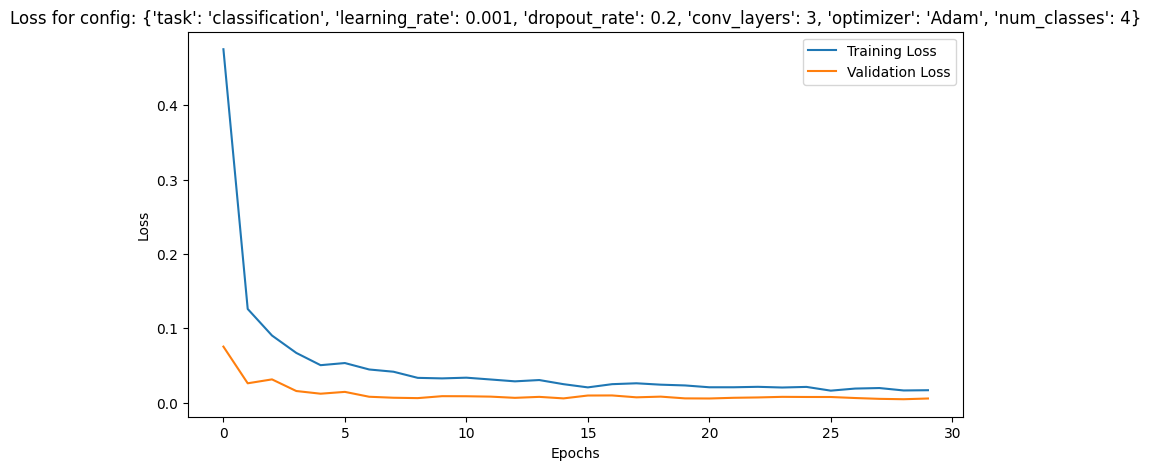

Running with config: {'task': 'classification', 'learning_rate': 0.0005, 'dropout_rate': 0.3, 'conv_layers': 3, 'optimizer': 'SGD', 'momentum': 0.9, 'num_classes': 4}
Validation Loss: 0.1547, Validation Accuracy: 94.5479%


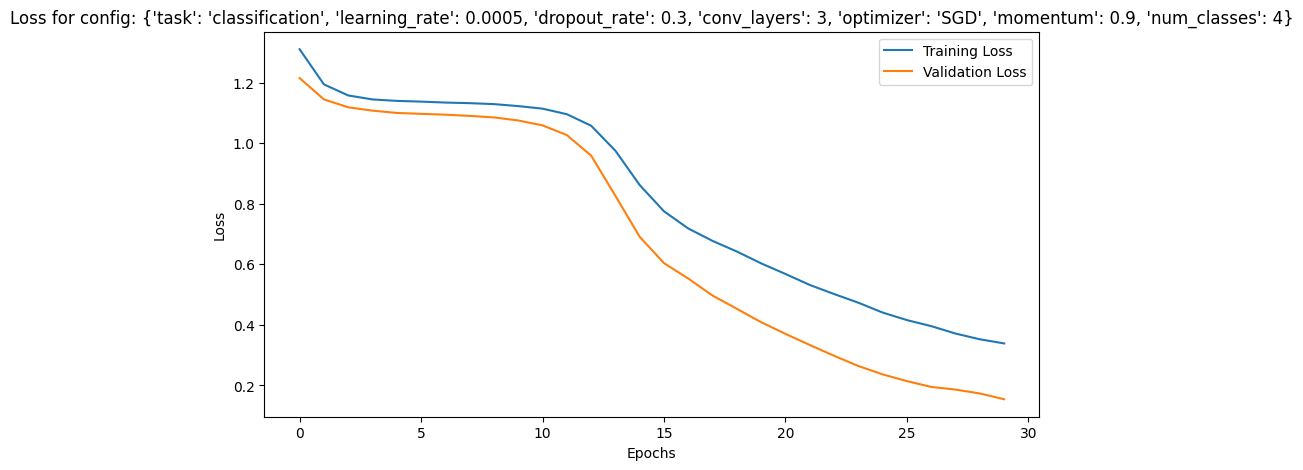

Running with config: {'task': 'classification', 'learning_rate': 0.002, 'dropout_rate': 0.4, 'conv_layers': 3, 'optimizer': 'RMSprop', 'num_classes': 4}
Validation Loss: 0.0170, Validation Accuracy: 99.5346%


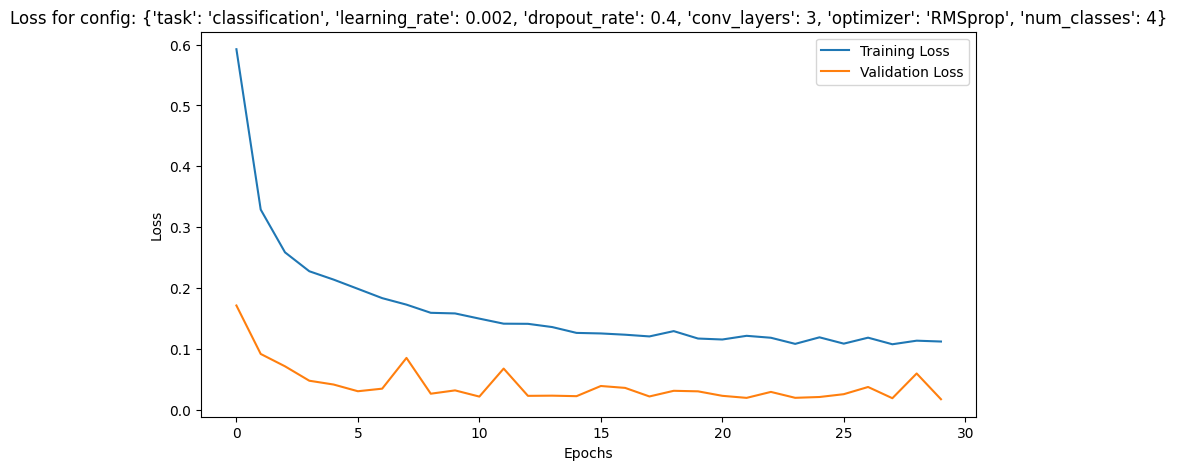

Running with config: {'task': 'classification', 'learning_rate': 0.0001, 'dropout_rate': 0.25, 'conv_layers': 2, 'optimizer': 'Adam', 'num_classes': 4}
Validation Loss: 0.1131, Validation Accuracy: 98.4043%


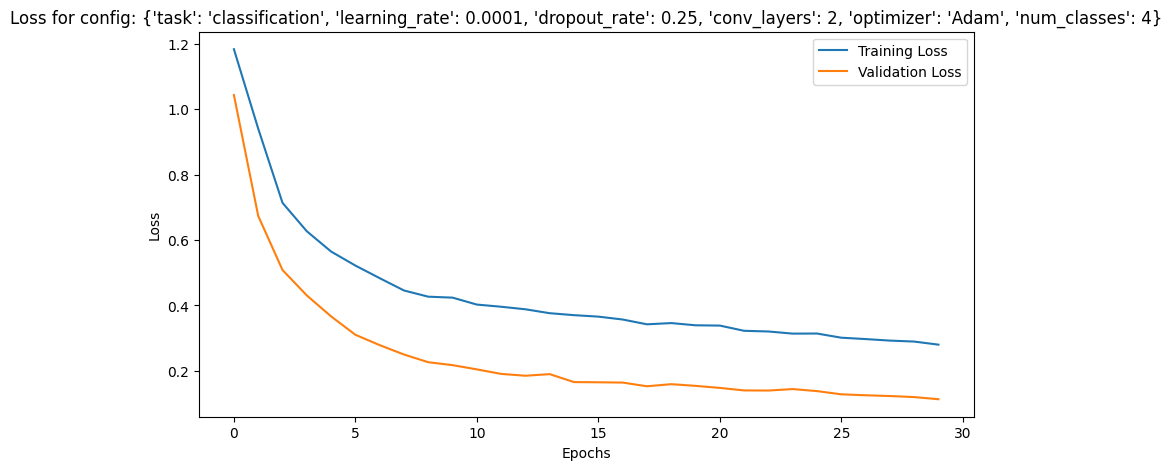

Running with config: {'task': 'classification', 'learning_rate': 0.005, 'dropout_rate': 0.1, 'conv_layers': 2, 'optimizer': 'SGD', 'momentum': 0.85, 'num_classes': 4}
Validation Loss: 0.0183, Validation Accuracy: 99.6343%


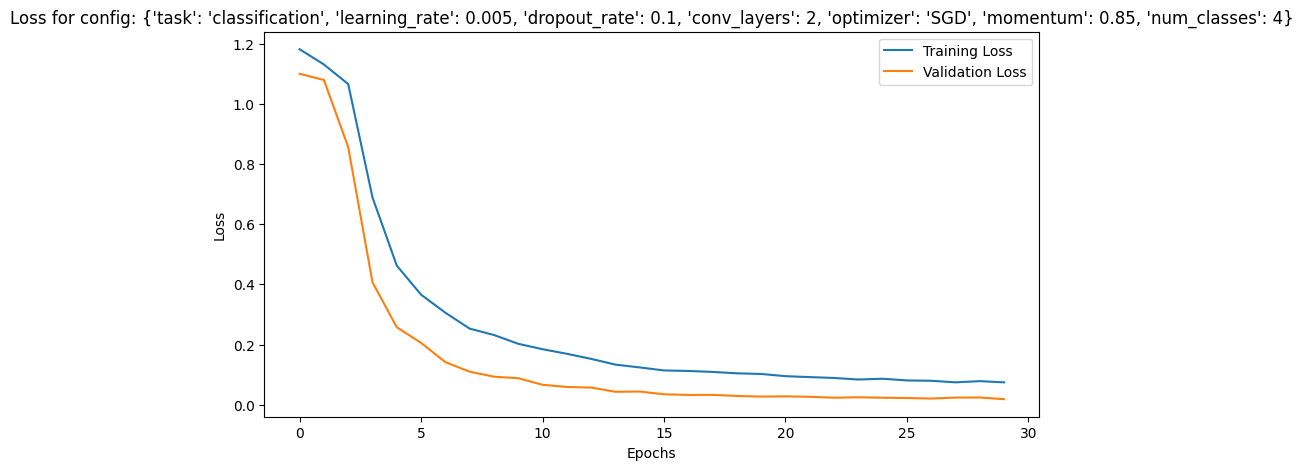

Running with config: {'task': 'classification', 'learning_rate': 0.001, 'dropout_rate': 0.0, 'conv_layers': 2, 'optimizer': 'Adam', 'num_classes': 4}
Validation Loss: 0.0167, Validation Accuracy: 99.6011%


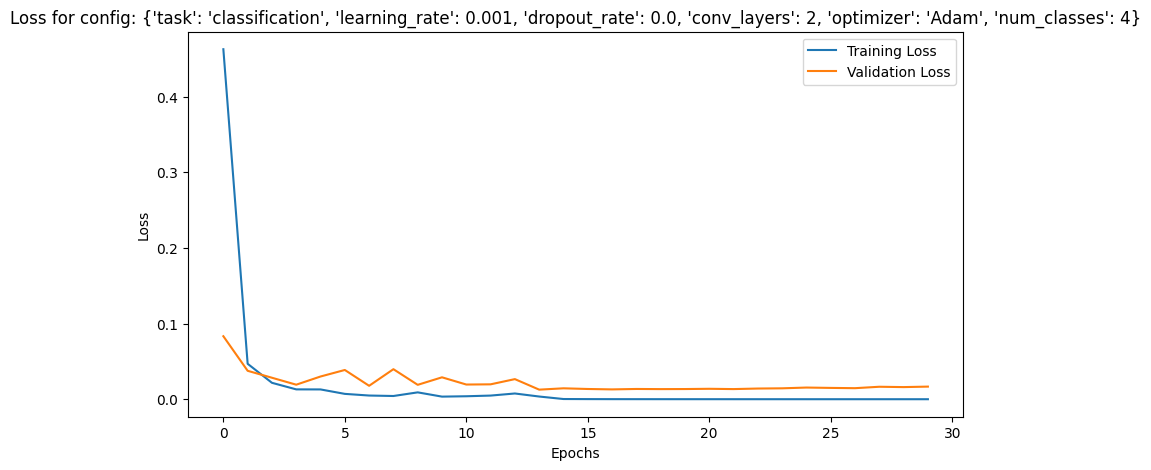

Best config: {'task': 'classification', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'conv_layers': 3, 'optimizer': 'Adam', 'num_classes': 4}


In [9]:
classification_configs = [
    {
        "task": "classification",
        "learning_rate": 0.001,
        "dropout_rate": 0.2,
        "conv_layers": 3,
        "optimizer": "Adam",
        "num_classes": 4
    },
    {
        "task": "classification",
        "learning_rate": 0.0005,
        "dropout_rate": 0.3,
        "conv_layers": 3,
        "optimizer": "SGD",
        "momentum": 0.9,
        "num_classes": 4
    },
    {
        "task": "classification",
        "learning_rate": 0.002,
        "dropout_rate": 0.4,
        "conv_layers": 3,
        "optimizer": "RMSprop",
        "num_classes": 4
    },
    {
        "task": "classification",
        "learning_rate": 0.0001,
        "dropout_rate": 0.25,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 4
    },
    {
        "task": "classification",
        "learning_rate": 0.005,
        "dropout_rate": 0.1,
        "conv_layers": 2,
        "optimizer": "SGD",
        "momentum": 0.85,
        "num_classes": 4
    },

    {
        "task": "classification",
        "learning_rate": 0.001,
        "dropout_rate": 0.0,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 4
    }
]

best_model_config_classification = tune(train_loader_classification, val_loader_classification, classification_configs, num_epochs=30, device=device)


In [10]:
best_model_config_classification = eval(best_model_config_classification)

In [38]:
best_model_classification = CNN(num_classes=4, num_conv_layers=best_model_config_classification['conv_layers'],
                                dropout_rate=best_model_config_classification['dropout_rate'], task='classification').to(device)

if best_model_config_classification['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model_classification.parameters(), lr=best_model_config_classification['learning_rate'])
elif best_model_config_classification['optimizer'] == 'SGD':
    optimizer = optim.SGD(best_model_classification.parameters(), lr=best_model_config_classification['learning_rate'], momentum=best_model_config_classification['momentum'])
elif best_model_config_classification['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(best_model_classification.parameters(), lr=best_model_config_classification['learning_rate'])

best_model_classification.train_model(optimizer, train_loader_classification, val_loader_classification, num_epochs=30, device=device)
val_loss , val_accuracy = best_model_classification.evaluate(val_loader_classification, device)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy*100:.4f}%")
test_loss, test_accuracy = best_model_classification.evaluate(test_loader_classification, device)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy*100:.4f}%")

Epoch 1/30: 100%|██████████| 394/394 [00:08<00:00, 47.52it/s, Loss=0.0799]


Epoch 1/30 - Train Loss: 0.4726, Validation Loss: 0.0780, Validation Accuracy: 98.2491


Epoch 2/30: 100%|██████████| 394/394 [00:06<00:00, 60.10it/s, Loss=0.3159]


Epoch 2/30 - Train Loss: 0.1247, Validation Loss: 0.0286, Validation Accuracy: 99.4016


Epoch 3/30: 100%|██████████| 394/394 [00:07<00:00, 53.47it/s, Loss=0.0243]


Epoch 3/30 - Train Loss: 0.0818, Validation Loss: 0.0228, Validation Accuracy: 99.3905


Epoch 4/30: 100%|██████████| 394/394 [00:07<00:00, 50.39it/s, Loss=0.1496]


Epoch 4/30 - Train Loss: 0.0635, Validation Loss: 0.0207, Validation Accuracy: 99.5235


Epoch 5/30: 100%|██████████| 394/394 [00:05<00:00, 72.67it/s, Loss=0.1192]


Epoch 5/30 - Train Loss: 0.0587, Validation Loss: 0.0123, Validation Accuracy: 99.7008


Epoch 6/30: 100%|██████████| 394/394 [00:05<00:00, 72.68it/s, Loss=0.0204]


Epoch 6/30 - Train Loss: 0.0471, Validation Loss: 0.0094, Validation Accuracy: 99.8338


Epoch 7/30: 100%|██████████| 394/394 [00:05<00:00, 72.23it/s, Loss=0.0006]


Epoch 7/30 - Train Loss: 0.0451, Validation Loss: 0.0089, Validation Accuracy: 99.7673


Epoch 8/30: 100%|██████████| 394/394 [00:06<00:00, 57.05it/s, Loss=0.0056]


Epoch 8/30 - Train Loss: 0.0399, Validation Loss: 0.0080, Validation Accuracy: 99.7673


Epoch 9/30: 100%|██████████| 394/394 [00:06<00:00, 62.28it/s, Loss=0.0020]


Epoch 9/30 - Train Loss: 0.0425, Validation Loss: 0.0060, Validation Accuracy: 99.8338


Epoch 10/30: 100%|██████████| 394/394 [00:05<00:00, 68.70it/s, Loss=0.0028]


Epoch 10/30 - Train Loss: 0.0402, Validation Loss: 0.0107, Validation Accuracy: 99.7673


Epoch 11/30: 100%|██████████| 394/394 [00:05<00:00, 71.90it/s, Loss=0.1316]


Epoch 11/30 - Train Loss: 0.0363, Validation Loss: 0.0094, Validation Accuracy: 99.7340


Epoch 12/30: 100%|██████████| 394/394 [00:08<00:00, 48.84it/s, Loss=0.0045]


Epoch 12/30 - Train Loss: 0.0378, Validation Loss: 0.0050, Validation Accuracy: 99.8338


Epoch 13/30: 100%|██████████| 394/394 [00:06<00:00, 58.61it/s, Loss=0.0041]


Epoch 13/30 - Train Loss: 0.0341, Validation Loss: 0.0068, Validation Accuracy: 99.8005


Epoch 14/30: 100%|██████████| 394/394 [00:06<00:00, 61.45it/s, Loss=0.0349]


Epoch 14/30 - Train Loss: 0.0318, Validation Loss: 0.0082, Validation Accuracy: 99.7673


Epoch 15/30: 100%|██████████| 394/394 [00:06<00:00, 61.65it/s, Loss=0.0071]


Epoch 15/30 - Train Loss: 0.0298, Validation Loss: 0.0049, Validation Accuracy: 99.8670


Epoch 16/30: 100%|██████████| 394/394 [00:06<00:00, 59.74it/s, Loss=0.0004]


Epoch 16/30 - Train Loss: 0.0251, Validation Loss: 0.0033, Validation Accuracy: 99.8670


Epoch 17/30: 100%|██████████| 394/394 [00:07<00:00, 53.34it/s, Loss=0.0062]


Epoch 17/30 - Train Loss: 0.0265, Validation Loss: 0.0048, Validation Accuracy: 99.8227


Epoch 18/30: 100%|██████████| 394/394 [00:06<00:00, 59.25it/s, Loss=0.0002]


Epoch 18/30 - Train Loss: 0.0263, Validation Loss: 0.0042, Validation Accuracy: 99.8670


Epoch 19/30: 100%|██████████| 394/394 [00:06<00:00, 58.61it/s, Loss=0.0063]


Epoch 19/30 - Train Loss: 0.0254, Validation Loss: 0.0061, Validation Accuracy: 99.8005


Epoch 20/30: 100%|██████████| 394/394 [00:06<00:00, 57.83it/s, Loss=0.0057]


Epoch 20/30 - Train Loss: 0.0210, Validation Loss: 0.0065, Validation Accuracy: 99.8670


Epoch 21/30: 100%|██████████| 394/394 [00:06<00:00, 58.02it/s, Loss=0.0024]


Epoch 21/30 - Train Loss: 0.0239, Validation Loss: 0.0057, Validation Accuracy: 99.7673


Epoch 22/30: 100%|██████████| 394/394 [00:06<00:00, 59.41it/s, Loss=0.0219]


Epoch 22/30 - Train Loss: 0.0248, Validation Loss: 0.0034, Validation Accuracy: 99.8670


Epoch 23/30: 100%|██████████| 394/394 [00:06<00:00, 60.61it/s, Loss=0.0086]


Epoch 23/30 - Train Loss: 0.0203, Validation Loss: 0.0065, Validation Accuracy: 99.8005


Epoch 24/30: 100%|██████████| 394/394 [00:06<00:00, 61.04it/s, Loss=0.1110]


Epoch 24/30 - Train Loss: 0.0201, Validation Loss: 0.0031, Validation Accuracy: 99.8338


Epoch 25/30: 100%|██████████| 394/394 [00:06<00:00, 60.97it/s, Loss=0.0003]


Epoch 25/30 - Train Loss: 0.0176, Validation Loss: 0.0048, Validation Accuracy: 99.8670


Epoch 26/30: 100%|██████████| 394/394 [00:06<00:00, 57.47it/s, Loss=0.0015]


Epoch 26/30 - Train Loss: 0.0232, Validation Loss: 0.0034, Validation Accuracy: 99.8338


Epoch 27/30: 100%|██████████| 394/394 [00:06<00:00, 60.22it/s, Loss=0.1222]


Epoch 27/30 - Train Loss: 0.0194, Validation Loss: 0.0072, Validation Accuracy: 99.7673


Epoch 28/30: 100%|██████████| 394/394 [00:07<00:00, 51.68it/s, Loss=0.0053]


Epoch 28/30 - Train Loss: 0.0186, Validation Loss: 0.0035, Validation Accuracy: 99.8338


Epoch 29/30: 100%|██████████| 394/394 [00:08<00:00, 47.65it/s, Loss=0.0007]


Epoch 29/30 - Train Loss: 0.0176, Validation Loss: 0.0036, Validation Accuracy: 99.8005


Epoch 30/30: 100%|██████████| 394/394 [00:07<00:00, 55.40it/s, Loss=0.0102]


Epoch 30/30 - Train Loss: 0.0167, Validation Loss: 0.0033, Validation Accuracy: 99.9003
Validation Loss: 0.003348165423005262, Validation Accuracy: 99.9003%
Test Loss: 0.0021171545633605782, Test Accuracy: 99.9349%


In [13]:
train_data_regression = MultiMNISTDataset(train_data, train_labels, task='regression')
val_data_regression = MultiMNISTDataset(val_data, val_labels, task='regression')
test_data_regression = MultiMNISTDataset(test_data, test_labels, task='regression')

train_loader_regression = DataLoader(train_data_regression, batch_size=32, shuffle=True)
val_loader_regression = DataLoader(val_data_regression, batch_size=32, shuffle=False)
test_loader_regression = DataLoader(test_data_regression, batch_size=32, shuffle=False)

Running with config: {'task': 'regression', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'conv_layers': 3, 'optimizer': 'Adam', 'num_classes': 4}
Validation Loss: 0.0175, Validation Accuracy: 99.5678%


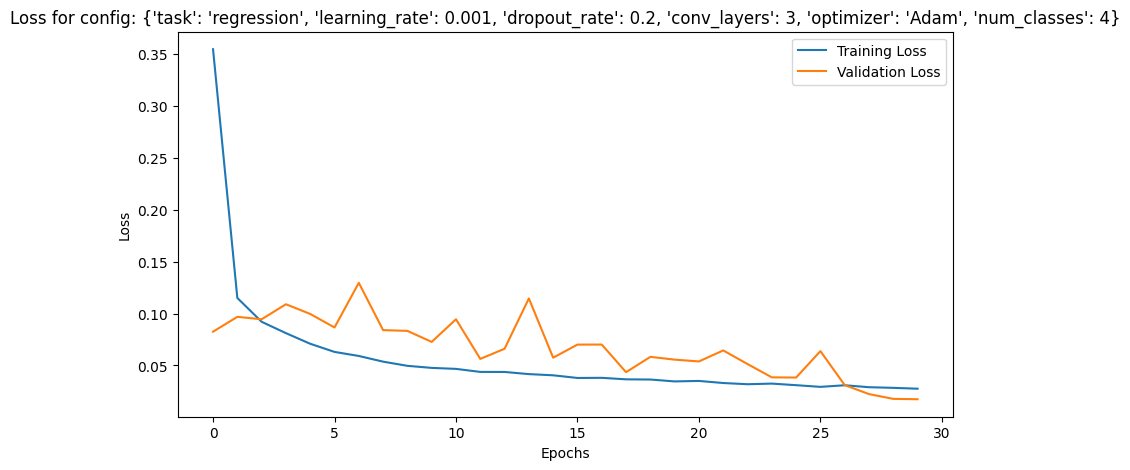

Running with config: {'task': 'regression', 'learning_rate': 0.0005, 'dropout_rate': 0.3, 'conv_layers': 3, 'optimizer': 'SGD', 'momentum': 0.9, 'num_classes': 4}
Validation Loss: 0.1228, Validation Accuracy: 85.4167%


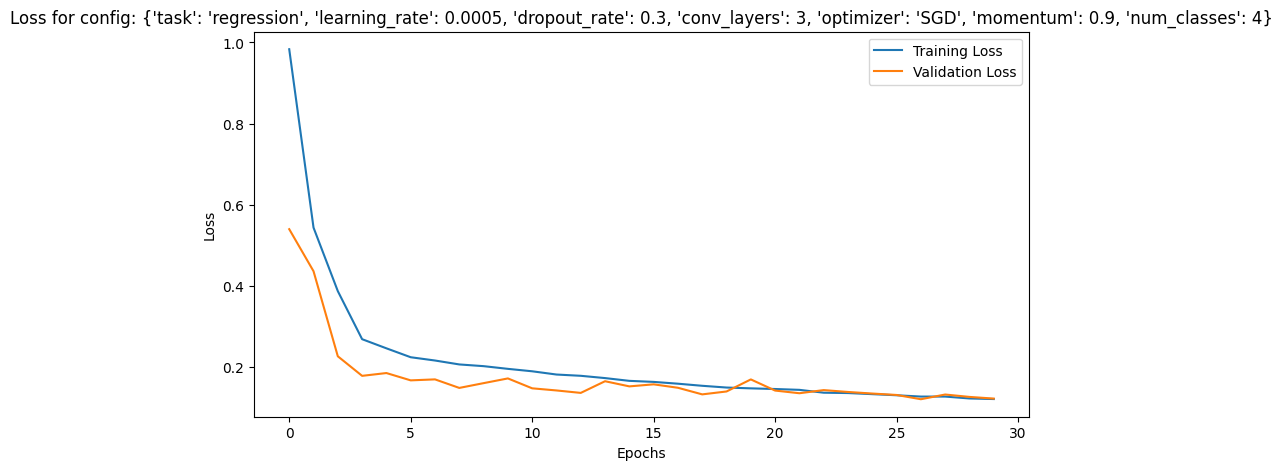

Running with config: {'task': 'regression', 'learning_rate': 0.002, 'dropout_rate': 0.4, 'conv_layers': 3, 'optimizer': 'RMSprop', 'num_classes': 4}
Validation Loss: 0.1491, Validation Accuracy: 73.4929%


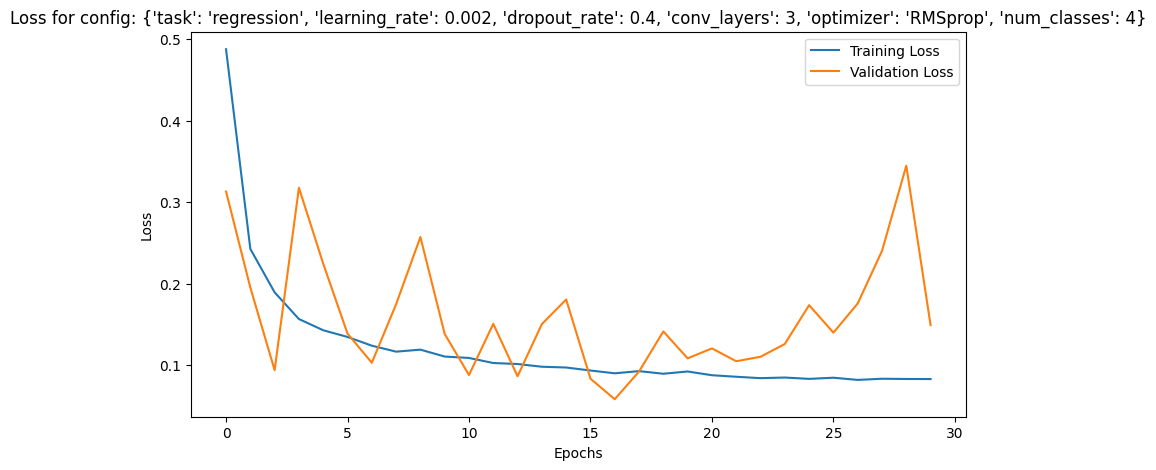

Running with config: {'task': 'regression', 'learning_rate': 0.0001, 'dropout_rate': 0.25, 'conv_layers': 2, 'optimizer': 'Adam', 'num_classes': 4}
Validation Loss: 0.1000, Validation Accuracy: 89.4947%


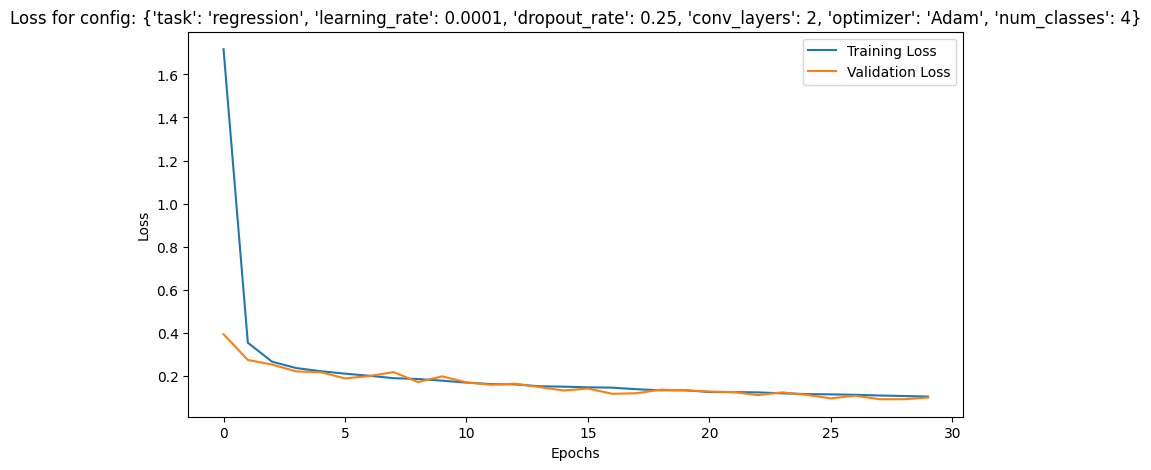

Running with config: {'task': 'regression', 'learning_rate': 0.005, 'dropout_rate': 0.1, 'conv_layers': 2, 'optimizer': 'SGD', 'momentum': 0.85, 'num_classes': 4}
Validation Loss: 0.0329, Validation Accuracy: 98.9029%


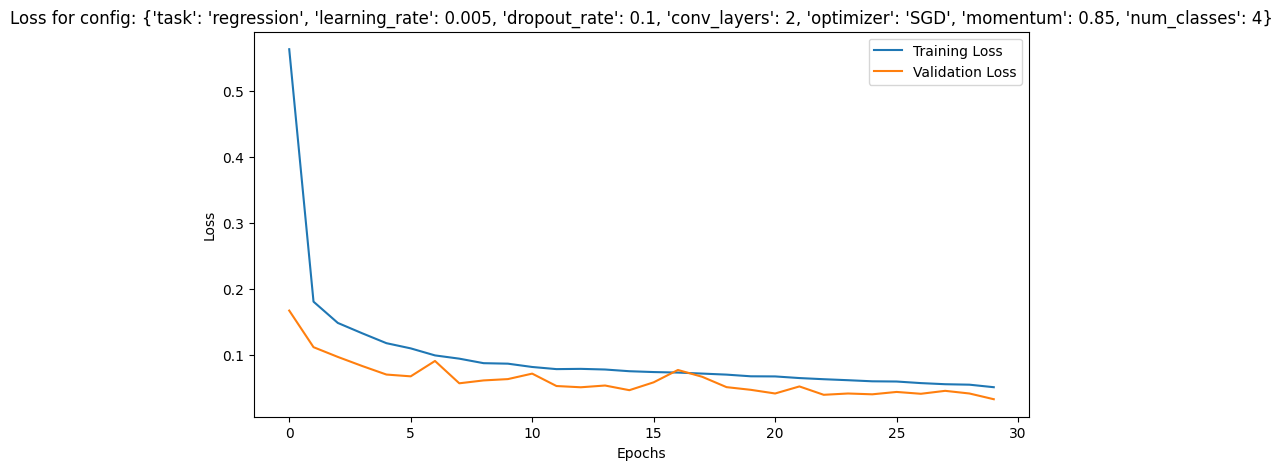

Running with config: {'task': 'regression', 'learning_rate': 0.001, 'dropout_rate': 0.0, 'conv_layers': 2, 'optimizer': 'Adam', 'num_classes': 4}
Validation Loss: 0.0131, Validation Accuracy: 99.7673%


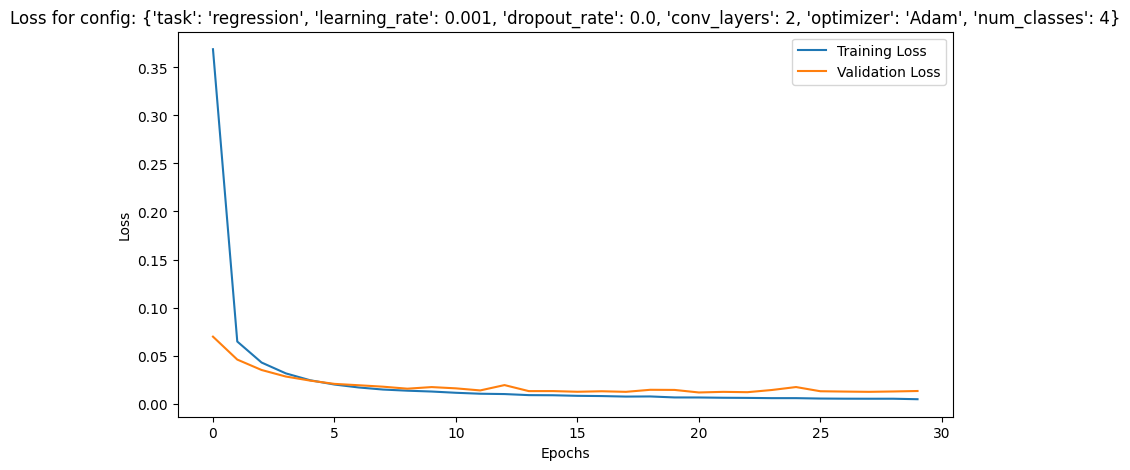

Best config: {'task': 'regression', 'learning_rate': 0.001, 'dropout_rate': 0.0, 'conv_layers': 2, 'optimizer': 'Adam', 'num_classes': 4}


In [14]:
regression_configs = [
    {
        "task": "regression",
        "learning_rate": 0.001,
        "dropout_rate": 0.2,
        "conv_layers": 3,
        "optimizer": "Adam",
        "num_classes": 4
    },
    {
        "task": "regression",
        "learning_rate": 0.0005,
        "dropout_rate": 0.3,
        "conv_layers": 3,
        "optimizer": "SGD",
        "momentum": 0.9,
        "num_classes": 4
    },
    {
        "task": "regression",
        "learning_rate": 0.002,
        "dropout_rate": 0.4,
        "conv_layers": 3,
        "optimizer": "RMSprop",
        "num_classes": 4
    },
    {
        "task": "regression",
        "learning_rate": 0.0001,
        "dropout_rate": 0.25,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 4
    },
    {
        "task": "regression",
        "learning_rate": 0.005,
        "dropout_rate": 0.1,
        "conv_layers": 2,
        "optimizer": "SGD",
        "momentum": 0.85,
        "num_classes": 4
    },

    {
        "task": "regression",
        "learning_rate": 0.001,
        "dropout_rate": 0.0,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 4
    }
]

best_model_config_regression = tune(train_loader_regression, val_loader_regression, regression_configs, num_epochs=30, device=device)

In [15]:
best_model_config_regression = eval(best_model_config_regression)

In [16]:
best_model_regression = CNN(num_classes=1, num_conv_layers=best_model_config_regression['conv_layers'], dropout_rate=best_model_config_regression['dropout_rate'], task='regression').to(device)

if best_model_config_regression['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model_regression.parameters(), lr=best_model_config_regression['learning_rate'])
elif best_model_config_regression['optimizer'] == 'SGD':
    optimizer = optim.SGD(best_model_regression.parameters(), lr=best_model_config_regression['learning_rate'], momentum=best_model_config_regression['momentum'])
elif best_model_config_regression['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(best_model_regression.parameters(), lr=best_model_config_regression['learning_rate'])

best_model_regression.train_model(optimizer, train_loader_regression, val_loader_regression, num_epochs=30, device=device)

val_loss, val_accuracy = best_model_regression.evaluate(val_loader_regression, device)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy*100:.4f}%")
test_loss, test_accuracy = best_model_regression.evaluate(test_loader_regression, device)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy*100:.4f}%")

Epoch 1/30: 100%|██████████| 394/394 [00:10<00:00, 37.91it/s, Loss=0.1436]


Epoch 1/30 - Train Loss: 0.3570, Validation Loss: 0.1143, Validation Accuracy: 86.2367


Epoch 2/30: 100%|██████████| 394/394 [00:10<00:00, 38.21it/s, Loss=0.0564]


Epoch 2/30 - Train Loss: 0.0908, Validation Loss: 0.0663, Validation Accuracy: 94.6144


Epoch 3/30: 100%|██████████| 394/394 [00:11<00:00, 34.18it/s, Loss=0.0577]


Epoch 3/30 - Train Loss: 0.0564, Validation Loss: 0.0465, Validation Accuracy: 97.9721


Epoch 4/30: 100%|██████████| 394/394 [00:14<00:00, 26.87it/s, Loss=0.0436]


Epoch 4/30 - Train Loss: 0.0390, Validation Loss: 0.0313, Validation Accuracy: 98.7367


Epoch 5/30: 100%|██████████| 394/394 [00:12<00:00, 31.74it/s, Loss=0.0255]


Epoch 5/30 - Train Loss: 0.0288, Validation Loss: 0.0294, Validation Accuracy: 98.9029


Epoch 6/30: 100%|██████████| 394/394 [00:12<00:00, 31.41it/s, Loss=0.0211]


Epoch 6/30 - Train Loss: 0.0234, Validation Loss: 0.0224, Validation Accuracy: 99.4681


Epoch 7/30: 100%|██████████| 394/394 [00:12<00:00, 32.00it/s, Loss=0.0137]


Epoch 7/30 - Train Loss: 0.0191, Validation Loss: 0.0206, Validation Accuracy: 99.4681


Epoch 8/30: 100%|██████████| 394/394 [00:12<00:00, 32.22it/s, Loss=0.0083]


Epoch 8/30 - Train Loss: 0.0172, Validation Loss: 0.0230, Validation Accuracy: 99.8338


Epoch 9/30: 100%|██████████| 394/394 [00:12<00:00, 31.78it/s, Loss=0.0172]


Epoch 9/30 - Train Loss: 0.0155, Validation Loss: 0.0193, Validation Accuracy: 99.6011


Epoch 10/30: 100%|██████████| 394/394 [00:10<00:00, 37.28it/s, Loss=0.0127]


Epoch 10/30 - Train Loss: 0.0136, Validation Loss: 0.0151, Validation Accuracy: 100.0000


Epoch 11/30: 100%|██████████| 394/394 [00:09<00:00, 39.53it/s, Loss=0.0093]


Epoch 11/30 - Train Loss: 0.0125, Validation Loss: 0.0152, Validation Accuracy: 99.9335


Epoch 12/30: 100%|██████████| 394/394 [00:10<00:00, 38.45it/s, Loss=0.0158]


Epoch 12/30 - Train Loss: 0.0116, Validation Loss: 0.0136, Validation Accuracy: 99.9003


Epoch 13/30: 100%|██████████| 394/394 [00:10<00:00, 37.25it/s, Loss=0.0149]


Epoch 13/30 - Train Loss: 0.0103, Validation Loss: 0.0135, Validation Accuracy: 99.8670


Epoch 14/30: 100%|██████████| 394/394 [00:09<00:00, 42.94it/s, Loss=0.0168]


Epoch 14/30 - Train Loss: 0.0096, Validation Loss: 0.0144, Validation Accuracy: 100.0000


Epoch 15/30: 100%|██████████| 394/394 [00:09<00:00, 41.40it/s, Loss=0.0041]


Epoch 15/30 - Train Loss: 0.0097, Validation Loss: 0.0115, Validation Accuracy: 99.9668


Epoch 16/30: 100%|██████████| 394/394 [00:09<00:00, 41.27it/s, Loss=0.0093]


Epoch 16/30 - Train Loss: 0.0084, Validation Loss: 0.0132, Validation Accuracy: 99.9668


Epoch 17/30: 100%|██████████| 394/394 [00:11<00:00, 33.46it/s, Loss=0.0101]


Epoch 17/30 - Train Loss: 0.0084, Validation Loss: 0.0109, Validation Accuracy: 99.9668


Epoch 18/30: 100%|██████████| 394/394 [00:10<00:00, 37.86it/s, Loss=0.0094]


Epoch 18/30 - Train Loss: 0.0078, Validation Loss: 0.0107, Validation Accuracy: 99.9668


Epoch 19/30: 100%|██████████| 394/394 [00:09<00:00, 39.87it/s, Loss=0.0065]


Epoch 19/30 - Train Loss: 0.0078, Validation Loss: 0.0113, Validation Accuracy: 100.0000


Epoch 20/30: 100%|██████████| 394/394 [00:13<00:00, 28.43it/s, Loss=0.0067]


Epoch 20/30 - Train Loss: 0.0070, Validation Loss: 0.0120, Validation Accuracy: 99.9335


Epoch 21/30: 100%|██████████| 394/394 [00:11<00:00, 35.03it/s, Loss=0.0076]


Epoch 21/30 - Train Loss: 0.0068, Validation Loss: 0.0100, Validation Accuracy: 99.9668


Epoch 22/30: 100%|██████████| 394/394 [00:09<00:00, 39.54it/s, Loss=0.0054]


Epoch 22/30 - Train Loss: 0.0069, Validation Loss: 0.0097, Validation Accuracy: 99.9668


Epoch 23/30: 100%|██████████| 394/394 [00:09<00:00, 40.59it/s, Loss=0.0039]


Epoch 23/30 - Train Loss: 0.0061, Validation Loss: 0.0125, Validation Accuracy: 99.9668


Epoch 24/30: 100%|██████████| 394/394 [00:10<00:00, 36.91it/s, Loss=0.0060]


Epoch 24/30 - Train Loss: 0.0061, Validation Loss: 0.0103, Validation Accuracy: 99.9668


Epoch 25/30: 100%|██████████| 394/394 [00:09<00:00, 39.51it/s, Loss=0.0095]


Epoch 25/30 - Train Loss: 0.0057, Validation Loss: 0.0108, Validation Accuracy: 99.9335


Epoch 26/30: 100%|██████████| 394/394 [00:09<00:00, 41.44it/s, Loss=0.0127]


Epoch 26/30 - Train Loss: 0.0057, Validation Loss: 0.0121, Validation Accuracy: 99.9668


Epoch 27/30: 100%|██████████| 394/394 [00:09<00:00, 41.92it/s, Loss=0.0052]


Epoch 27/30 - Train Loss: 0.0052, Validation Loss: 0.0085, Validation Accuracy: 99.9668


Epoch 28/30: 100%|██████████| 394/394 [00:10<00:00, 39.11it/s, Loss=0.0079]


Epoch 28/30 - Train Loss: 0.0053, Validation Loss: 0.0099, Validation Accuracy: 100.0000


Epoch 29/30: 100%|██████████| 394/394 [00:09<00:00, 42.87it/s, Loss=0.0031]


Epoch 29/30 - Train Loss: 0.0051, Validation Loss: 0.0084, Validation Accuracy: 100.0000


Epoch 30/30: 100%|██████████| 394/394 [00:10<00:00, 39.04it/s, Loss=0.0053]


Epoch 30/30 - Train Loss: 0.0049, Validation Loss: 0.0090, Validation Accuracy: 99.9668
Validation Loss: 0.008974774702708485, Validation Accuracy: 99.9668%
Test Loss: 0.00918577355443833, Test Accuracy: 99.9349%


### 2.4 Feature map Visualization

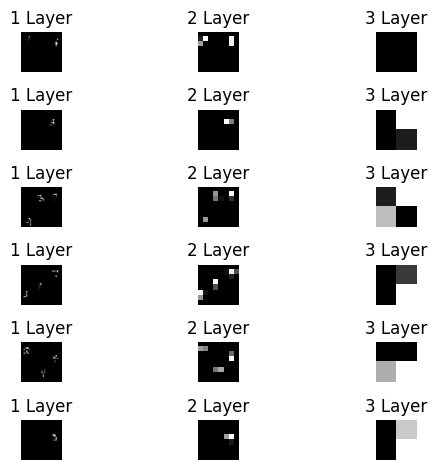

In [40]:
best_model_classification.visulize_feature_maps(train_loader_classification, device=device)

Inference
- In the first layer it tries to detect the separate loacations of the foreground to get number of digits in the image.
- In the second layer it tries to reduce it to single pixel for each different location of the digit.
- In the third layer it predicts the digit by reducing the image such that it has four different shades of gray corresponding to the four possible number of digits.

## 3 Multi Label Classification

### 3.1 Data Loading and Preprocessing

In [17]:
def load_mnist_data_multilabel(path):
    splits = ['train', 'val', 'test']
    data = {'train': [], 'val': [], 'test': []}
    labels = {'train': [], 'val': [], 'test': []}
    for split in splits:
        split_path = os.path.join(path, split)
        for label in os.listdir(split_path):
            label_path = os.path.join(split_path, label)
            if (len(label) == 1 and int(label) == 0):
                cur_label = []
            else:
                cur_label = [int(i) for i in label]
            if os.path.isdir(label_path):
                for image_name in os.listdir(label_path):
                    image_path = os.path.join(label_path, image_name)
                    try:
                        image = Image.open(image_path).convert('L')
                        image_array = np.array(image)
                        data[split].append(image_array)
                        labels[split].append(cur_label)
                    except Exception as e:
                        print(f"Error loading image {image_name}: {e}")
    
    return data['train'], labels['train'], data['val'], labels['val'], data['test'], labels['test']

In [18]:
def get_one_hot(y):
    one_hot = np.zeros(33)
    if len(y) == 0:
        y.append(10)
        y.append(10)
        y.append(10)
    elif len(y) == 1:
        y.append(10)
        y.append(10)
    elif len(y) == 2:
        y.append(10)
    for i in range(len(y)):
        one_hot[y[i]+10*i+i] = 1
    return one_hot

In [19]:
class MultiMNISTDataset_mulitlabel(Dataset):
    def __init__(self, images, labels, task='multilabel_classification', transform=None):
        self.images = images
        self.labels = labels
        self.task = task
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float32) / 255.0
        image = image.unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        if self.task == 'multilabel_classification':
            label = torch.tensor(label, dtype=torch.float32).to(device)
        else:
            label = torch.tensor(label, dtype=torch.float32).to(device).unsqueeze(0)
        return image, label


### 3.2 Implement the MultiLabelCNN Class

In [30]:
class CNN_Multilabel(nn.Module):
    def __init__(self, num_classes=33, num_conv_layers=3, dropout_rate=0.0, task='multilabel_classification'):
        super(CNN_Multilabel, self).__init__()

        self.task = task
        self.num_classes = num_classes
        self.num_conv_layers = num_conv_layers
        self.dropout_rate = dropout_rate
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for i in range(num_conv_layers):
            if i == 0:
                setattr(self, f'conv{i+1}', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=1))
            else:
                setattr(self, f'conv{i+1}', nn.Conv2d(in_channels=32 * (2 ** (i - 1)), out_channels=32 * (2 ** i), kernel_size=3, stride=2, padding=1))
            
            setattr(self, f'dropout{i+1}', nn.Dropout(dropout_rate))

        self.fc1 = None
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.fc_dropout = nn.Dropout(dropout_rate)

    def _initialize_fc(self, input_shape, device):
        dummy_input = torch.zeros(1, *input_shape).to(device)
        with torch.no_grad():
            output = self._forward_conv(dummy_input)
        flattened_size = output.view(-1).shape[0]
        self.fc1 = nn.Linear(flattened_size, 128).to(device)

    def _forward_conv(self, x):
        for i in range(self.num_conv_layers):
            conv_layer = getattr(self, f'conv{i+1}')
            dropout_layer = getattr(self, f'dropout{i+1}')
            x = self.pool(self.relu(conv_layer(x)))
            x = dropout_layer(x)
        return x

    def forward(self, x):
        if self.fc1 is None:
            self._initialize_fc(x.shape[1:], x.device)

        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc_dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_accuracy(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            y_pred_labels = self.convert_to_labels(y_pred)
            y_true_labels = self.convert_to_labels(y_true)
            accuracy = 0
            for i in range(len(y_pred_labels)):
                flag = 1
                if len(y_pred_labels[i]) == len(y_true_labels[i]):
                    for j in range(len(y_pred_labels[i])):
                        if y_pred_labels[i][j] != y_true_labels[i][j]:
                            flag = 0
                            break
                else:
                    flag = 0
                accuracy += flag
            return accuracy / len(y_pred_labels)
        else:
            return F.mse_loss(y_pred, y_true)

    def loss(self, y_pred, y_true):
        if self.task == 'multilabel_classification':
            criterion = nn.CrossEntropyLoss()
            loss = 0
            for i in range(3):
                start = i * 11
                end = (i + 1) * 11
                target_idx = torch.argmax(y_true[:, start:end], dim=1)
                loss += criterion(y_pred[:, start:end], target_idx)
            return loss
        else:
            return F.mse_loss(y_pred, y_true)
        
    def get_hamming_accuracy(self, data_loader, device):
        self.eval()
        correct = 0
        incorrect = 0
        with torch.no_grad():
            for x, y in data_loader:
                x, y = x.to(device), y.to(device)
                y_pred = self.forward(x)
                y_pred_labels = self.convert_to_labels(y_pred)
                y_true_labels = self.convert_to_labels(y)
                for i in range(len(y_pred_labels)):
                    if y_pred_labels[i] == y_true_labels[i]:
                        correct += 1
                    else:
                        incorrect += 1
        return correct / (correct + incorrect)

    def convert_to_labels(self, y_pred):
        labels = []
        batch_size = y_pred.shape[0]
        for i in range(batch_size):
            label = []
            for j in range(3):
                start = j * 11
                end = (j + 1) * 11
                cur_label = torch.argmax(y_pred[i, start:end]).item()
                if cur_label != 10:
                    label.append(cur_label)
                else:
                    break
            labels.append(label)
        return labels
    
    def train_model(self, optimizer, train_loader, val_loader, num_epochs=30, device='cpu', tune=False):
        self.to(device)
        avg_train_losses = []
        avg_val_losses = []

        for epoch in range(num_epochs):
            self.train()

            if not tune:
                train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}")
            else:
                train_progress = enumerate(train_loader)
            
            total_train_loss = 0
            for i, (x, y) in train_progress:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_pred = self.forward(x)
                loss = self.loss(y_pred, y)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()

                if not tune:
                    train_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

            avg_train_loss = total_train_loss / len(train_loader)
            avg_train_losses.append(avg_train_loss)
            avg_val_loss, avg_val_accuracy = self.evaluate(val_loader, device)
            avg_val_losses.append(avg_val_loss)

            if not tune:
                print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_accuracy*100:.4f}%")

        return avg_train_losses, avg_val_losses
    
    def evaluate(self, data_loader, device):
        self.eval()
        total_loss = 0.0
        total_accuracy = 0.0

        with torch.no_grad():
            for x, y in data_loader:
                x, y = x.to(device), y.to(device)
                y_pred = self.forward(x)
                total_loss += self.loss(y_pred, y).item()
                total_accuracy += self.get_accuracy(y_pred, y)
        
        avg_loss = total_loss / len(data_loader)
        avg_accuracy = total_accuracy / len(data_loader)
        
        return avg_loss, avg_accuracy

In [21]:
train_data_multilabel, train_labels_multilabel, val_data_multilabel, val_labels_multilabel, test_data_multilabel, test_labels_multilabel = load_mnist_data_multilabel(data_path)

In [22]:
train_labels_multilabel_one_hot = [get_one_hot(y) for y in train_labels_multilabel]
val_labels_multilabel_one_hot = [get_one_hot(y) for y in val_labels_multilabel]
test_labels_multilabel_one_hot = [get_one_hot(y) for y in test_labels_multilabel]

In [23]:

train_data_multilabel = MultiMNISTDataset_mulitlabel(train_data_multilabel, train_labels_multilabel_one_hot)
val_data_multilabel = MultiMNISTDataset_mulitlabel(val_data_multilabel, val_labels_multilabel_one_hot)
test_data_multilabel = MultiMNISTDataset_mulitlabel(test_data_multilabel, test_labels_multilabel_one_hot)

train_loader_multilabel = DataLoader(train_data_multilabel, batch_size=32, shuffle=True)
val_loader_multilabel = DataLoader(val_data_multilabel, batch_size=32, shuffle=False)
test_loader_multilabel = DataLoader(test_data_multilabel, batch_size=32, shuffle=False)

### 3.3 Hyperparameter Tuning

In [24]:
def tune_multilabel(train_loader, val_loader, configs, num_epochs=30, device='cpu'):
    results = {}

    for config in configs:
        model = CNN_Multilabel(
            num_classes=config['num_classes'], 
            num_conv_layers=config['conv_layers'], 
            dropout_rate=config['dropout_rate'], 
            task=config['task']
        ).to(device)

        if config['optimizer'] == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        elif config['optimizer'] == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
        elif config['optimizer'] == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=config['learning_rate'])

        train_losses, val_losses = model.train_model(optimizer, train_loader, val_loader, num_epochs=num_epochs, device=device, tune=True)

        results[str(config)] = {
            'train_loss': train_losses,
            'val_loss': val_losses
        }

        val_loss, val_accuracy = model.evaluate(val_loader, device)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy*100:.4f}%")

        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Training and Validation Loss for Config: {config}")
        plt.legend()
        plt.show()
        
    best_config = None
    best_val_loss = float('inf')
    for config, data in results.items():
        if data['val_loss'][-1] < best_val_loss:
            best_val_loss = data['val_loss'][-1]
            best_config = config

    print(f"Best config: {best_config}")
    return best_config


In [25]:
multilabel_classification_configs = [
    {
        "task": "multilabel_classification",
        "learning_rate": 0.001,
        "dropout_rate": 0.2,
        "conv_layers": 3,
        "optimizer": "Adam",
        "num_classes": 33
    },
    {
        "task": "multilabel_classification",
        "learning_rate": 0.0005,
        "dropout_rate": 0.3,
        "conv_layers": 3,
        "optimizer": "SGD",
        "momentum": 0.9,
        "num_classes": 33
    },
    {
        "task": "multilabel_classification",
        "learning_rate": 0.002,
        "dropout_rate": 0.4,
        "conv_layers": 3,
        "optimizer": "RMSprop",
        "num_classes": 33
    },
    {
        "task": "multilabel_classification",
        "learning_rate": 0.0001,
        "dropout_rate": 0.25,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 33
    },
    {
        "task": "multilabel_classification",
        "learning_rate": 0.005,
        "dropout_rate": 0.1,
        "conv_layers": 2,
        "optimizer": "SGD",
        "momentum": 0.85,
        "num_classes": 33
    },

    {
        "task": "multilabel_classification",
        "learning_rate": 0.001,
        "dropout_rate": 0.0,
        "conv_layers": 2,
        "optimizer": "Adam",
        "num_classes": 33
    }
]

Validation Loss: 2.9406, Validation Accuracy: 24.1578%


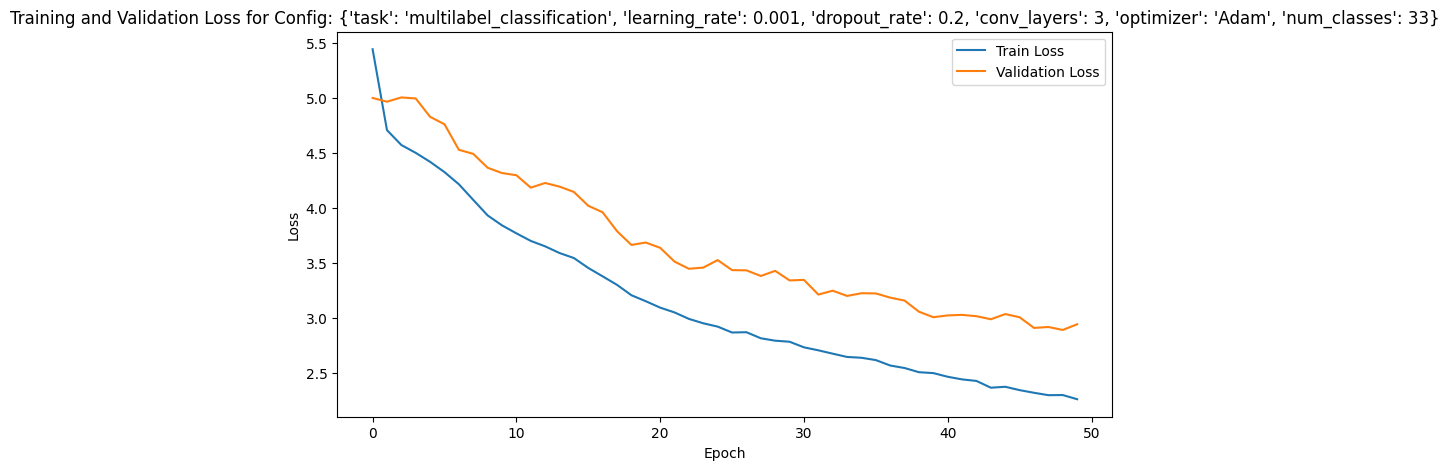

Validation Loss: 4.9348, Validation Accuracy: 3.7234%


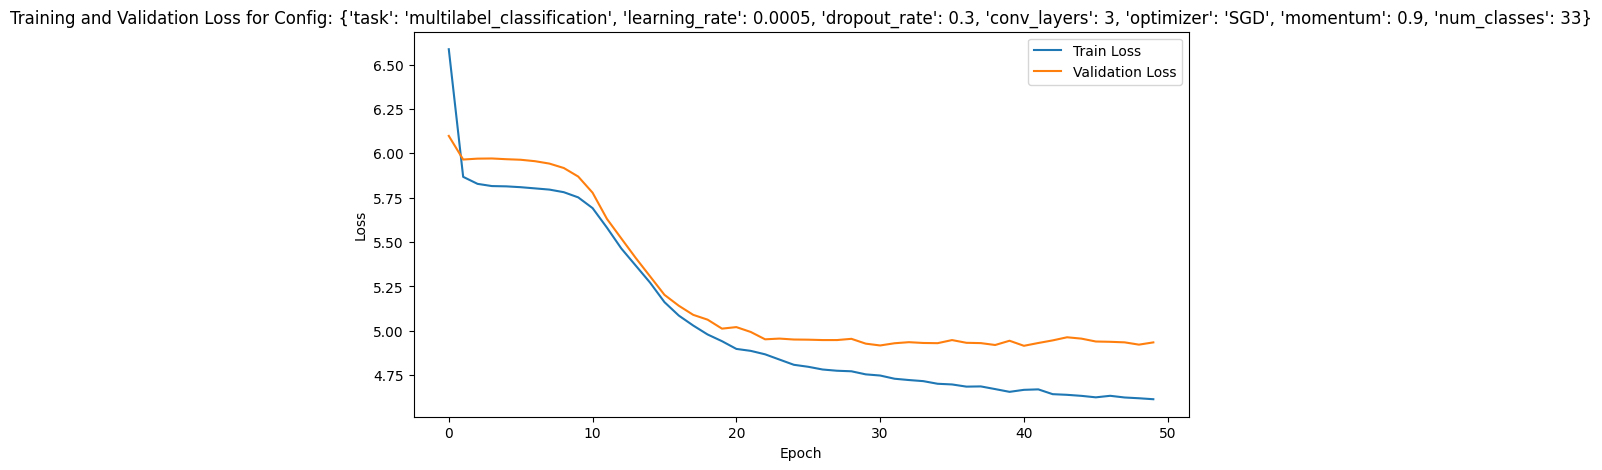

Validation Loss: 3.8120, Validation Accuracy: 8.1228%


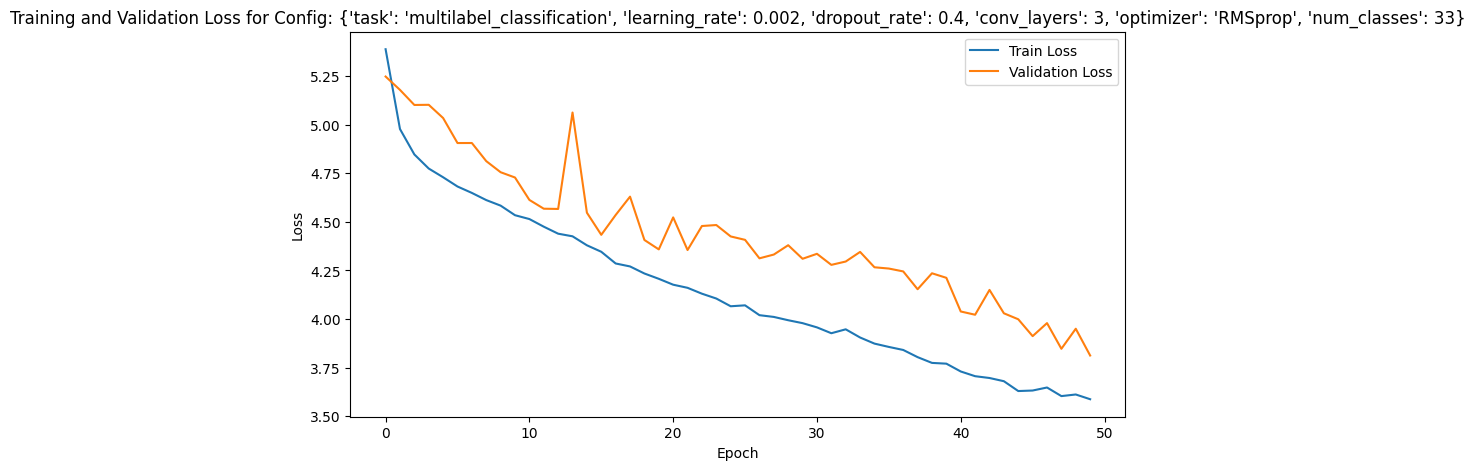

Validation Loss: 4.9099, Validation Accuracy: 4.2553%


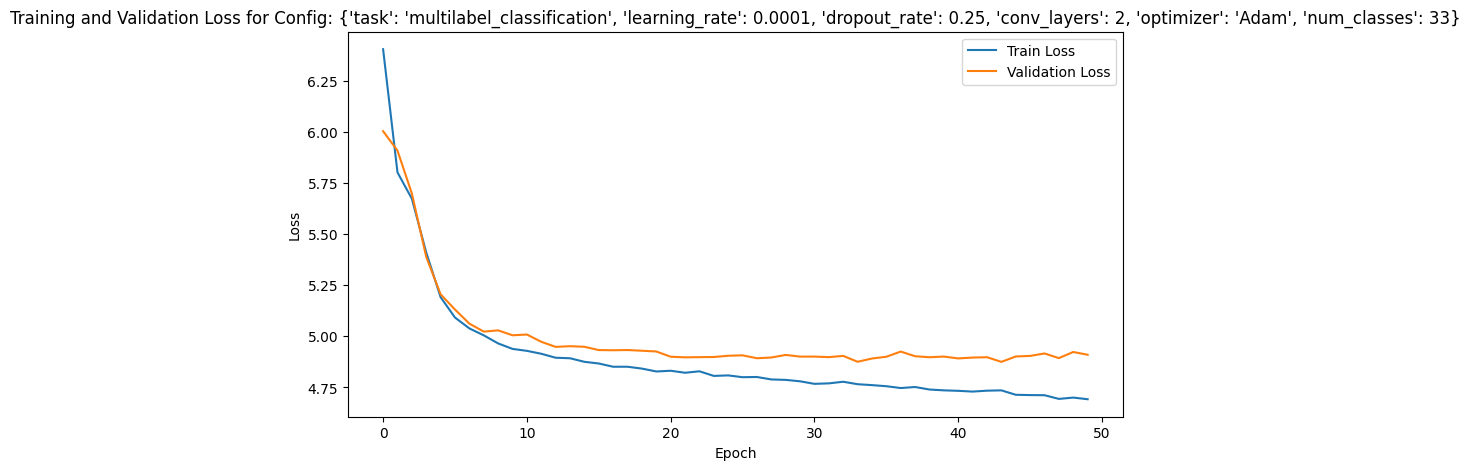

Validation Loss: 4.7633, Validation Accuracy: 4.1888%


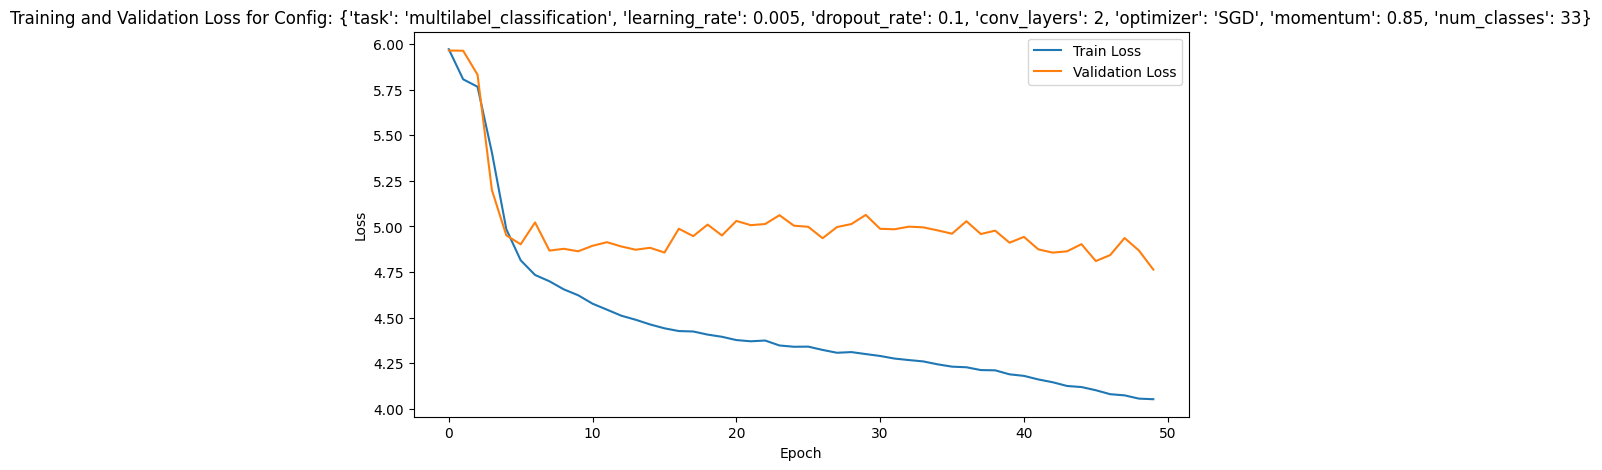

Validation Loss: 5.1547, Validation Accuracy: 5.8067%


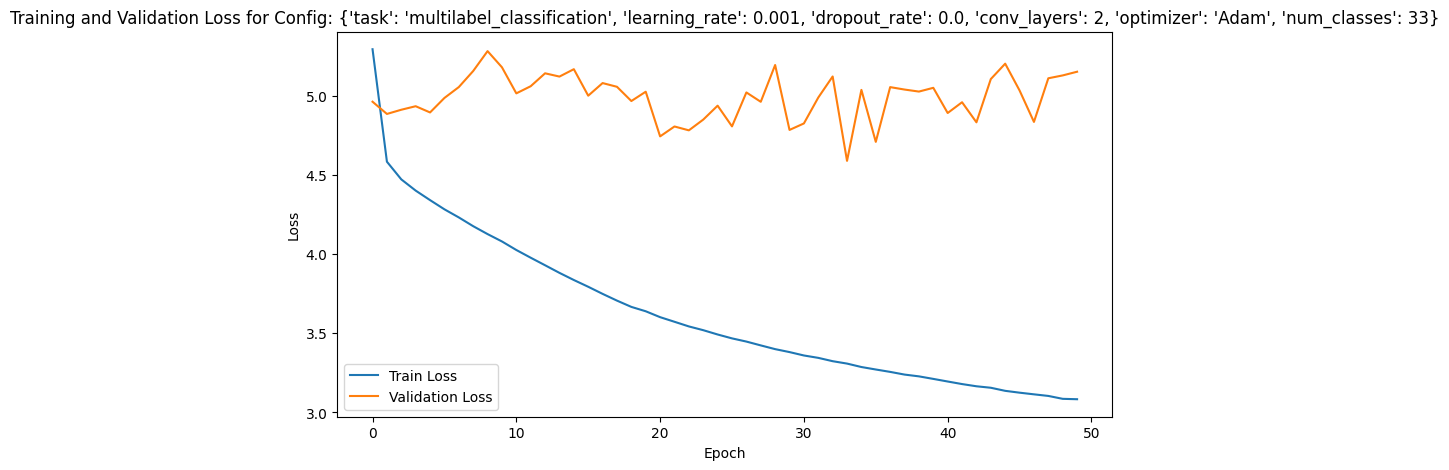

Best config: {'task': 'multilabel_classification', 'learning_rate': 0.001, 'dropout_rate': 0.2, 'conv_layers': 3, 'optimizer': 'Adam', 'num_classes': 33}


In [26]:
best_model_config_Multilabel = tune_multilabel(train_loader_multilabel, val_loader_multilabel, multilabel_classification_configs, num_epochs=50, device=device)

In [27]:
best_model_config_Multilabel = eval(best_model_config_Multilabel)

In [34]:
best_model_multilabel = CNN_Multilabel(
    num_classes=33, 
    num_conv_layers=best_model_config_Multilabel['conv_layers'], 
    dropout_rate=best_model_config_Multilabel['dropout_rate'], 
    task='multilabel_classification'
).to(device)

if best_model_config_Multilabel['optimizer'] == 'Adam':
    optimizer = optim.Adam(best_model_multilabel.parameters(), lr=best_model_config_Multilabel['learning_rate'])
elif best_model_config_Multilabel['optimizer'] == 'SGD':
    optimizer = optim.SGD(best_model_multilabel.parameters(), lr=best_model_config_Multilabel['learning_rate'], momentum=best_model_config_Multilabel['momentum'])
elif best_model_config_Multilabel['optimizer'] == 'RMSprop':
    optimizer = optim.RMSprop(best_model_multilabel.parameters(), lr=best_model_config_Multilabel['learning_rate'])

_,_ = best_model_multilabel.train_model(optimizer, train_loader_multilabel, val_loader_multilabel, num_epochs=150, device=device)

Epoch 1/150: 100%|██████████| 394/394 [00:07<00:00, 53.18it/s, Loss=5.6889]


Epoch 1/150 - Train Loss: 5.3809, Validation Loss: 4.9735, Validation Accuracy: 3.4907%


Epoch 2/150: 100%|██████████| 394/394 [00:08<00:00, 44.14it/s, Loss=4.1273]


Epoch 2/150 - Train Loss: 4.7275, Validation Loss: 4.9437, Validation Accuracy: 4.0226%


Epoch 3/150: 100%|██████████| 394/394 [00:07<00:00, 53.64it/s, Loss=4.3102]


Epoch 3/150 - Train Loss: 4.5791, Validation Loss: 4.9732, Validation Accuracy: 4.2886%


Epoch 4/150: 100%|██████████| 394/394 [00:07<00:00, 55.51it/s, Loss=4.5773]


Epoch 4/150 - Train Loss: 4.4893, Validation Loss: 4.9335, Validation Accuracy: 5.4965%


Epoch 5/150: 100%|██████████| 394/394 [00:07<00:00, 55.16it/s, Loss=3.9220]


Epoch 5/150 - Train Loss: 4.4166, Validation Loss: 4.9367, Validation Accuracy: 4.0891%


Epoch 6/150: 100%|██████████| 394/394 [00:07<00:00, 54.22it/s, Loss=4.5468]


Epoch 6/150 - Train Loss: 4.3340, Validation Loss: 4.7165, Validation Accuracy: 3.6237%


Epoch 7/150: 100%|██████████| 394/394 [00:07<00:00, 55.01it/s, Loss=4.5092]


Epoch 7/150 - Train Loss: 4.2378, Validation Loss: 4.6338, Validation Accuracy: 3.7234%


Epoch 8/150: 100%|██████████| 394/394 [00:06<00:00, 57.68it/s, Loss=4.1222]


Epoch 8/150 - Train Loss: 4.1229, Validation Loss: 4.6250, Validation Accuracy: 5.3524%


Epoch 9/150: 100%|██████████| 394/394 [00:06<00:00, 58.27it/s, Loss=3.8278]


Epoch 9/150 - Train Loss: 4.0037, Validation Loss: 4.2391, Validation Accuracy: 5.5186%


Epoch 10/150: 100%|██████████| 394/394 [00:06<00:00, 58.62it/s, Loss=3.7816]


Epoch 10/150 - Train Loss: 3.9117, Validation Loss: 4.2995, Validation Accuracy: 4.2221%


Epoch 11/150: 100%|██████████| 394/394 [00:06<00:00, 58.87it/s, Loss=3.3591]


Epoch 11/150 - Train Loss: 3.8297, Validation Loss: 4.2443, Validation Accuracy: 6.0505%


Epoch 12/150: 100%|██████████| 394/394 [00:06<00:00, 59.32it/s, Loss=4.0012]


Epoch 12/150 - Train Loss: 3.7589, Validation Loss: 4.1682, Validation Accuracy: 4.6543%


Epoch 13/150: 100%|██████████| 394/394 [00:06<00:00, 58.62it/s, Loss=2.9713]


Epoch 13/150 - Train Loss: 3.7045, Validation Loss: 4.1412, Validation Accuracy: 4.9535%


Epoch 14/150: 100%|██████████| 394/394 [00:06<00:00, 58.99it/s, Loss=3.5401]


Epoch 14/150 - Train Loss: 3.6430, Validation Loss: 4.0445, Validation Accuracy: 5.9840%


Epoch 15/150: 100%|██████████| 394/394 [00:06<00:00, 57.54it/s, Loss=3.2300]


Epoch 15/150 - Train Loss: 3.6006, Validation Loss: 4.2267, Validation Accuracy: 3.9561%


Epoch 16/150: 100%|██████████| 394/394 [00:07<00:00, 52.94it/s, Loss=3.1964]


Epoch 16/150 - Train Loss: 3.5554, Validation Loss: 4.0686, Validation Accuracy: 5.5851%


Epoch 17/150: 100%|██████████| 394/394 [00:07<00:00, 54.20it/s, Loss=3.6680]


Epoch 17/150 - Train Loss: 3.4971, Validation Loss: 4.0994, Validation Accuracy: 4.5213%


Epoch 18/150: 100%|██████████| 394/394 [00:08<00:00, 45.37it/s, Loss=3.4772]


Epoch 18/150 - Train Loss: 3.4405, Validation Loss: 4.0196, Validation Accuracy: 5.9508%


Epoch 19/150: 100%|██████████| 394/394 [00:07<00:00, 55.13it/s, Loss=3.8473]


Epoch 19/150 - Train Loss: 3.4155, Validation Loss: 3.9225, Validation Accuracy: 6.6822%


Epoch 20/150: 100%|██████████| 394/394 [00:06<00:00, 56.45it/s, Loss=3.6344]


Epoch 20/150 - Train Loss: 3.3522, Validation Loss: 3.9526, Validation Accuracy: 6.2832%


Epoch 21/150: 100%|██████████| 394/394 [00:07<00:00, 55.94it/s, Loss=3.5368]


Epoch 21/150 - Train Loss: 3.2863, Validation Loss: 3.8345, Validation Accuracy: 6.5270%


Epoch 22/150: 100%|██████████| 394/394 [00:06<00:00, 56.37it/s, Loss=3.2293]


Epoch 22/150 - Train Loss: 3.2277, Validation Loss: 3.8191, Validation Accuracy: 5.9840%


Epoch 23/150: 100%|██████████| 394/394 [00:07<00:00, 56.02it/s, Loss=2.7142]


Epoch 23/150 - Train Loss: 3.1514, Validation Loss: 3.7503, Validation Accuracy: 6.8484%


Epoch 24/150: 100%|██████████| 394/394 [00:07<00:00, 55.95it/s, Loss=3.0467]


Epoch 24/150 - Train Loss: 3.0757, Validation Loss: 3.5356, Validation Accuracy: 9.8072%


Epoch 25/150: 100%|██████████| 394/394 [00:07<00:00, 52.00it/s, Loss=2.4797]


Epoch 25/150 - Train Loss: 2.9982, Validation Loss: 3.5063, Validation Accuracy: 8.9761%


Epoch 26/150: 100%|██████████| 394/394 [00:07<00:00, 55.65it/s, Loss=2.9974]


Epoch 26/150 - Train Loss: 2.9769, Validation Loss: 3.4808, Validation Accuracy: 8.9428%


Epoch 27/150: 100%|██████████| 394/394 [00:06<00:00, 56.65it/s, Loss=2.8643]


Epoch 27/150 - Train Loss: 2.9045, Validation Loss: 3.4461, Validation Accuracy: 9.2420%


Epoch 28/150: 100%|██████████| 394/394 [00:06<00:00, 57.05it/s, Loss=4.2853]


Epoch 28/150 - Train Loss: 2.8504, Validation Loss: 3.4427, Validation Accuracy: 10.8710%


Epoch 29/150: 100%|██████████| 394/394 [00:06<00:00, 57.59it/s, Loss=2.5338]


Epoch 29/150 - Train Loss: 2.7947, Validation Loss: 3.3981, Validation Accuracy: 10.8267%


Epoch 30/150: 100%|██████████| 394/394 [00:07<00:00, 55.76it/s, Loss=2.5249]


Epoch 30/150 - Train Loss: 2.7648, Validation Loss: 3.3215, Validation Accuracy: 11.0594%


Epoch 31/150: 100%|██████████| 394/394 [00:07<00:00, 55.67it/s, Loss=2.0207]


Epoch 31/150 - Train Loss: 2.7431, Validation Loss: 3.2733, Validation Accuracy: 11.4805%


Epoch 32/150: 100%|██████████| 394/394 [00:07<00:00, 55.30it/s, Loss=2.8032]


Epoch 32/150 - Train Loss: 2.6997, Validation Loss: 3.1256, Validation Accuracy: 14.0847%


Epoch 33/150: 100%|██████████| 394/394 [00:07<00:00, 52.54it/s, Loss=2.5282]


Epoch 33/150 - Train Loss: 2.6410, Validation Loss: 3.1529, Validation Accuracy: 12.7216%


Epoch 34/150: 100%|██████████| 394/394 [00:07<00:00, 54.44it/s, Loss=2.6665]


Epoch 34/150 - Train Loss: 2.6113, Validation Loss: 3.1069, Validation Accuracy: 14.5501%


Epoch 35/150: 100%|██████████| 394/394 [00:07<00:00, 55.34it/s, Loss=2.9734]


Epoch 35/150 - Train Loss: 2.5992, Validation Loss: 3.1272, Validation Accuracy: 14.7828%


Epoch 36/150: 100%|██████████| 394/394 [00:07<00:00, 54.10it/s, Loss=2.7891]


Epoch 36/150 - Train Loss: 2.5540, Validation Loss: 2.9321, Validation Accuracy: 19.3262%


Epoch 37/150: 100%|██████████| 394/394 [00:07<00:00, 53.43it/s, Loss=3.2058]


Epoch 37/150 - Train Loss: 2.5172, Validation Loss: 3.0818, Validation Accuracy: 17.1875%


Epoch 38/150: 100%|██████████| 394/394 [00:07<00:00, 54.41it/s, Loss=2.9952]


Epoch 38/150 - Train Loss: 2.4827, Validation Loss: 2.8525, Validation Accuracy: 20.5674%


Epoch 39/150: 100%|██████████| 394/394 [00:07<00:00, 53.98it/s, Loss=2.8820]


Epoch 39/150 - Train Loss: 2.4380, Validation Loss: 2.9223, Validation Accuracy: 18.1738%


Epoch 40/150: 100%|██████████| 394/394 [00:07<00:00, 55.11it/s, Loss=2.4182]


Epoch 40/150 - Train Loss: 2.4019, Validation Loss: 2.8405, Validation Accuracy: 20.3236%


Epoch 41/150: 100%|██████████| 394/394 [00:07<00:00, 54.13it/s, Loss=2.4478]


Epoch 41/150 - Train Loss: 2.3964, Validation Loss: 2.8079, Validation Accuracy: 21.1769%


Epoch 42/150: 100%|██████████| 394/394 [00:07<00:00, 54.08it/s, Loss=2.5168]


Epoch 42/150 - Train Loss: 2.3616, Validation Loss: 2.7764, Validation Accuracy: 21.9858%


Epoch 43/150: 100%|██████████| 394/394 [00:07<00:00, 53.29it/s, Loss=2.4871]


Epoch 43/150 - Train Loss: 2.3270, Validation Loss: 2.8487, Validation Accuracy: 22.4956%


Epoch 44/150: 100%|██████████| 394/394 [00:09<00:00, 42.36it/s, Loss=2.8756]


Epoch 44/150 - Train Loss: 2.3238, Validation Loss: 2.7731, Validation Accuracy: 24.6232%


Epoch 45/150: 100%|██████████| 394/394 [00:09<00:00, 43.11it/s, Loss=2.3309]


Epoch 45/150 - Train Loss: 2.2950, Validation Loss: 2.6998, Validation Accuracy: 25.9752%


Epoch 46/150: 100%|██████████| 394/394 [00:08<00:00, 44.08it/s, Loss=1.8241]


Epoch 46/150 - Train Loss: 2.2617, Validation Loss: 2.7343, Validation Accuracy: 25.0554%


Epoch 47/150: 100%|██████████| 394/394 [00:08<00:00, 44.77it/s, Loss=2.3741]


Epoch 47/150 - Train Loss: 2.2031, Validation Loss: 2.6892, Validation Accuracy: 25.9530%


Epoch 48/150: 100%|██████████| 394/394 [00:08<00:00, 48.28it/s, Loss=2.1205]


Epoch 48/150 - Train Loss: 2.2148, Validation Loss: 2.7276, Validation Accuracy: 26.4517%


Epoch 49/150: 100%|██████████| 394/394 [00:07<00:00, 50.78it/s, Loss=1.9720]


Epoch 49/150 - Train Loss: 2.1935, Validation Loss: 2.7183, Validation Accuracy: 27.6485%


Epoch 50/150: 100%|██████████| 394/394 [00:08<00:00, 48.05it/s, Loss=2.6114]


Epoch 50/150 - Train Loss: 2.1725, Validation Loss: 2.6556, Validation Accuracy: 26.9947%


Epoch 51/150: 100%|██████████| 394/394 [00:08<00:00, 47.80it/s, Loss=2.2403]


Epoch 51/150 - Train Loss: 2.1456, Validation Loss: 2.6344, Validation Accuracy: 29.0337%


Epoch 52/150: 100%|██████████| 394/394 [00:07<00:00, 49.37it/s, Loss=2.0742]


Epoch 52/150 - Train Loss: 2.1272, Validation Loss: 2.5591, Validation Accuracy: 29.7097%


Epoch 53/150: 100%|██████████| 394/394 [00:08<00:00, 46.57it/s, Loss=2.7055]


Epoch 53/150 - Train Loss: 2.1232, Validation Loss: 2.5631, Validation Accuracy: 30.8400%


Epoch 54/150: 100%|██████████| 394/394 [00:10<00:00, 36.53it/s, Loss=1.9071]


Epoch 54/150 - Train Loss: 2.0865, Validation Loss: 2.5985, Validation Accuracy: 28.0585%


Epoch 55/150: 100%|██████████| 394/394 [00:07<00:00, 51.67it/s, Loss=1.7394]


Epoch 55/150 - Train Loss: 2.0767, Validation Loss: 2.5476, Validation Accuracy: 31.0395%


Epoch 56/150: 100%|██████████| 394/394 [00:07<00:00, 51.14it/s, Loss=2.5830]


Epoch 56/150 - Train Loss: 2.0587, Validation Loss: 2.6091, Validation Accuracy: 30.2083%


Epoch 57/150: 100%|██████████| 394/394 [00:07<00:00, 53.50it/s, Loss=2.2763]


Epoch 57/150 - Train Loss: 2.0348, Validation Loss: 2.5606, Validation Accuracy: 31.5270%


Epoch 58/150: 100%|██████████| 394/394 [00:07<00:00, 54.87it/s, Loss=1.4214]


Epoch 58/150 - Train Loss: 1.9993, Validation Loss: 2.5229, Validation Accuracy: 33.1006%


Epoch 59/150: 100%|██████████| 394/394 [00:07<00:00, 55.14it/s, Loss=1.6620]


Epoch 59/150 - Train Loss: 1.9772, Validation Loss: 2.4541, Validation Accuracy: 35.1840%


Epoch 60/150: 100%|██████████| 394/394 [00:06<00:00, 57.45it/s, Loss=2.1297]


Epoch 60/150 - Train Loss: 1.9655, Validation Loss: 2.5085, Validation Accuracy: 33.1117%


Epoch 61/150: 100%|██████████| 394/394 [00:06<00:00, 56.65it/s, Loss=2.1195]


Epoch 61/150 - Train Loss: 1.9737, Validation Loss: 2.4783, Validation Accuracy: 33.2558%


Epoch 62/150: 100%|██████████| 394/394 [00:06<00:00, 56.32it/s, Loss=2.8685]


Epoch 62/150 - Train Loss: 1.9390, Validation Loss: 2.4791, Validation Accuracy: 33.0120%


Epoch 63/150: 100%|██████████| 394/394 [00:07<00:00, 52.12it/s, Loss=2.0709]


Epoch 63/150 - Train Loss: 1.9353, Validation Loss: 2.4255, Validation Accuracy: 34.6299%


Epoch 64/150: 100%|██████████| 394/394 [00:07<00:00, 54.31it/s, Loss=2.1188]


Epoch 64/150 - Train Loss: 1.9114, Validation Loss: 2.4382, Validation Accuracy: 34.1755%


Epoch 65/150: 100%|██████████| 394/394 [00:07<00:00, 53.41it/s, Loss=1.7202]


Epoch 65/150 - Train Loss: 1.8941, Validation Loss: 2.4675, Validation Accuracy: 34.4526%


Epoch 66/150: 100%|██████████| 394/394 [00:08<00:00, 47.75it/s, Loss=2.0463]


Epoch 66/150 - Train Loss: 1.8981, Validation Loss: 2.4263, Validation Accuracy: 36.0151%


Epoch 67/150: 100%|██████████| 394/394 [00:07<00:00, 53.36it/s, Loss=1.7284]


Epoch 67/150 - Train Loss: 1.8606, Validation Loss: 2.4277, Validation Accuracy: 35.3834%


Epoch 68/150: 100%|██████████| 394/394 [00:07<00:00, 51.06it/s, Loss=2.5905]


Epoch 68/150 - Train Loss: 1.8596, Validation Loss: 2.4387, Validation Accuracy: 35.5829%


Epoch 69/150: 100%|██████████| 394/394 [00:06<00:00, 56.37it/s, Loss=1.7161]


Epoch 69/150 - Train Loss: 1.8561, Validation Loss: 2.4701, Validation Accuracy: 36.2810%


Epoch 70/150: 100%|██████████| 394/394 [00:07<00:00, 53.02it/s, Loss=2.3813]


Epoch 70/150 - Train Loss: 1.8393, Validation Loss: 2.3970, Validation Accuracy: 37.1121%


Epoch 71/150: 100%|██████████| 394/394 [00:07<00:00, 51.05it/s, Loss=1.6788]


Epoch 71/150 - Train Loss: 1.8196, Validation Loss: 2.3109, Validation Accuracy: 37.9322%


Epoch 72/150: 100%|██████████| 394/394 [00:07<00:00, 54.16it/s, Loss=2.3773]


Epoch 72/150 - Train Loss: 1.8186, Validation Loss: 2.3470, Validation Accuracy: 38.3090%


Epoch 73/150: 100%|██████████| 394/394 [00:07<00:00, 53.11it/s, Loss=1.5343]


Epoch 73/150 - Train Loss: 1.8010, Validation Loss: 2.2868, Validation Accuracy: 39.3285%


Epoch 74/150: 100%|██████████| 394/394 [00:07<00:00, 53.14it/s, Loss=1.9942]


Epoch 74/150 - Train Loss: 1.7881, Validation Loss: 2.3770, Validation Accuracy: 38.7301%


Epoch 75/150: 100%|██████████| 394/394 [00:07<00:00, 52.94it/s, Loss=2.4322]


Epoch 75/150 - Train Loss: 1.7586, Validation Loss: 2.3402, Validation Accuracy: 38.2646%


Epoch 76/150: 100%|██████████| 394/394 [00:07<00:00, 51.74it/s, Loss=1.6047]


Epoch 76/150 - Train Loss: 1.7817, Validation Loss: 2.3742, Validation Accuracy: 38.9295%


Epoch 77/150: 100%|██████████| 394/394 [00:07<00:00, 54.37it/s, Loss=1.5234]


Epoch 77/150 - Train Loss: 1.7459, Validation Loss: 2.3021, Validation Accuracy: 39.8493%


Epoch 78/150: 100%|██████████| 394/394 [00:07<00:00, 53.35it/s, Loss=1.2980]


Epoch 78/150 - Train Loss: 1.7224, Validation Loss: 2.2057, Validation Accuracy: 39.8050%


Epoch 79/150: 100%|██████████| 394/394 [00:07<00:00, 53.88it/s, Loss=2.4779]


Epoch 79/150 - Train Loss: 1.7413, Validation Loss: 2.2604, Validation Accuracy: 39.7274%


Epoch 80/150: 100%|██████████| 394/394 [00:10<00:00, 37.14it/s, Loss=2.0484]


Epoch 80/150 - Train Loss: 1.7311, Validation Loss: 2.2486, Validation Accuracy: 41.5448%


Epoch 81/150: 100%|██████████| 394/394 [00:07<00:00, 53.94it/s, Loss=1.7787]


Epoch 81/150 - Train Loss: 1.7351, Validation Loss: 2.3433, Validation Accuracy: 39.4725%


Epoch 82/150: 100%|██████████| 394/394 [00:07<00:00, 53.60it/s, Loss=1.1445]


Epoch 82/150 - Train Loss: 1.6763, Validation Loss: 2.3099, Validation Accuracy: 39.2176%


Epoch 83/150: 100%|██████████| 394/394 [00:07<00:00, 54.05it/s, Loss=1.9254]


Epoch 83/150 - Train Loss: 1.6877, Validation Loss: 2.2693, Validation Accuracy: 41.3896%


Epoch 84/150: 100%|██████████| 394/394 [00:07<00:00, 53.34it/s, Loss=2.0288]


Epoch 84/150 - Train Loss: 1.6918, Validation Loss: 2.2867, Validation Accuracy: 39.8604%


Epoch 85/150: 100%|██████████| 394/394 [00:07<00:00, 53.70it/s, Loss=2.0937]


Epoch 85/150 - Train Loss: 1.6600, Validation Loss: 2.2441, Validation Accuracy: 40.9907%


Epoch 86/150: 100%|██████████| 394/394 [00:07<00:00, 54.23it/s, Loss=1.9640]


Epoch 86/150 - Train Loss: 1.6800, Validation Loss: 2.2287, Validation Accuracy: 41.8218%


Epoch 87/150: 100%|██████████| 394/394 [00:08<00:00, 48.87it/s, Loss=0.9294]


Epoch 87/150 - Train Loss: 1.6730, Validation Loss: 2.1909, Validation Accuracy: 40.0931%


Epoch 88/150: 100%|██████████| 394/394 [00:07<00:00, 52.96it/s, Loss=1.7304]


Epoch 88/150 - Train Loss: 1.6576, Validation Loss: 2.2388, Validation Accuracy: 41.1902%


Epoch 89/150: 100%|██████████| 394/394 [00:07<00:00, 53.67it/s, Loss=1.6381]


Epoch 89/150 - Train Loss: 1.6502, Validation Loss: 2.2133, Validation Accuracy: 42.6529%


Epoch 90/150: 100%|██████████| 394/394 [00:11<00:00, 34.33it/s, Loss=2.2669]


Epoch 90/150 - Train Loss: 1.6237, Validation Loss: 2.2458, Validation Accuracy: 40.8134%


Epoch 91/150: 100%|██████████| 394/394 [00:07<00:00, 53.26it/s, Loss=2.3036]


Epoch 91/150 - Train Loss: 1.6500, Validation Loss: 2.1984, Validation Accuracy: 41.4229%


Epoch 92/150: 100%|██████████| 394/394 [00:06<00:00, 60.76it/s, Loss=1.4396]


Epoch 92/150 - Train Loss: 1.6352, Validation Loss: 2.1886, Validation Accuracy: 43.2070%


Epoch 93/150: 100%|██████████| 394/394 [00:06<00:00, 60.11it/s, Loss=1.1475]


Epoch 93/150 - Train Loss: 1.6109, Validation Loss: 2.1185, Validation Accuracy: 43.7278%


Epoch 94/150: 100%|██████████| 394/394 [00:06<00:00, 61.23it/s, Loss=1.3039]


Epoch 94/150 - Train Loss: 1.6162, Validation Loss: 2.1704, Validation Accuracy: 43.1959%


Epoch 95/150: 100%|██████████| 394/394 [00:06<00:00, 62.15it/s, Loss=1.9708]


Epoch 95/150 - Train Loss: 1.5967, Validation Loss: 2.1505, Validation Accuracy: 42.5089%


Epoch 96/150: 100%|██████████| 394/394 [00:09<00:00, 43.05it/s, Loss=1.7764]


Epoch 96/150 - Train Loss: 1.6105, Validation Loss: 2.2558, Validation Accuracy: 42.4091%


Epoch 97/150: 100%|██████████| 394/394 [00:09<00:00, 43.21it/s, Loss=1.3238]


Epoch 97/150 - Train Loss: 1.6076, Validation Loss: 2.1388, Validation Accuracy: 43.4508%


Epoch 98/150: 100%|██████████| 394/394 [00:08<00:00, 48.87it/s, Loss=1.3057]


Epoch 98/150 - Train Loss: 1.5888, Validation Loss: 2.0870, Validation Accuracy: 43.4397%


Epoch 99/150: 100%|██████████| 394/394 [00:07<00:00, 53.22it/s, Loss=1.7760]


Epoch 99/150 - Train Loss: 1.6044, Validation Loss: 2.1190, Validation Accuracy: 42.9854%


Epoch 100/150: 100%|██████████| 394/394 [00:07<00:00, 52.82it/s, Loss=1.9235]


Epoch 100/150 - Train Loss: 1.5797, Validation Loss: 2.1304, Validation Accuracy: 43.4840%


Epoch 101/150: 100%|██████████| 394/394 [00:07<00:00, 54.10it/s, Loss=2.0040]


Epoch 101/150 - Train Loss: 1.5708, Validation Loss: 2.1930, Validation Accuracy: 41.9880%


Epoch 102/150: 100%|██████████| 394/394 [00:07<00:00, 52.99it/s, Loss=1.1105]


Epoch 102/150 - Train Loss: 1.5589, Validation Loss: 2.0907, Validation Accuracy: 44.0160%


Epoch 103/150: 100%|██████████| 394/394 [00:09<00:00, 40.31it/s, Loss=2.5255]


Epoch 103/150 - Train Loss: 1.5811, Validation Loss: 2.1289, Validation Accuracy: 44.1379%


Epoch 104/150: 100%|██████████| 394/394 [00:06<00:00, 57.22it/s, Loss=1.9546]


Epoch 104/150 - Train Loss: 1.5736, Validation Loss: 2.1529, Validation Accuracy: 44.7141%


Epoch 105/150: 100%|██████████| 394/394 [00:09<00:00, 43.60it/s, Loss=1.6059]


Epoch 105/150 - Train Loss: 1.5523, Validation Loss: 2.2061, Validation Accuracy: 43.2402%


Epoch 106/150: 100%|██████████| 394/394 [00:09<00:00, 42.37it/s, Loss=1.9430]


Epoch 106/150 - Train Loss: 1.5626, Validation Loss: 2.1874, Validation Accuracy: 43.3289%


Epoch 107/150: 100%|██████████| 394/394 [00:09<00:00, 41.71it/s, Loss=1.7148]


Epoch 107/150 - Train Loss: 1.5377, Validation Loss: 2.1343, Validation Accuracy: 45.9552%


Epoch 108/150: 100%|██████████| 394/394 [00:09<00:00, 41.64it/s, Loss=1.5634]


Epoch 108/150 - Train Loss: 1.5473, Validation Loss: 2.1148, Validation Accuracy: 43.1738%


Epoch 109/150: 100%|██████████| 394/394 [00:10<00:00, 37.89it/s, Loss=2.5729]


Epoch 109/150 - Train Loss: 1.5163, Validation Loss: 2.0653, Validation Accuracy: 46.6645%


Epoch 110/150: 100%|██████████| 394/394 [00:07<00:00, 51.35it/s, Loss=1.6403]


Epoch 110/150 - Train Loss: 1.5047, Validation Loss: 2.0671, Validation Accuracy: 45.5674%


Epoch 111/150: 100%|██████████| 394/394 [00:08<00:00, 49.05it/s, Loss=1.3147]


Epoch 111/150 - Train Loss: 1.5138, Validation Loss: 2.1238, Validation Accuracy: 43.6724%


Epoch 112/150: 100%|██████████| 394/394 [00:06<00:00, 58.11it/s, Loss=2.4025]


Epoch 112/150 - Train Loss: 1.5189, Validation Loss: 2.0615, Validation Accuracy: 46.6755%


Epoch 113/150: 100%|██████████| 394/394 [00:07<00:00, 55.39it/s, Loss=1.5967]


Epoch 113/150 - Train Loss: 1.5165, Validation Loss: 2.1587, Validation Accuracy: 44.8803%


Epoch 114/150: 100%|██████████| 394/394 [00:07<00:00, 52.57it/s, Loss=0.6491]


Epoch 114/150 - Train Loss: 1.5185, Validation Loss: 2.1332, Validation Accuracy: 44.7806%


Epoch 115/150: 100%|██████████| 394/394 [00:07<00:00, 50.09it/s, Loss=1.3082]


Epoch 115/150 - Train Loss: 1.5030, Validation Loss: 2.0976, Validation Accuracy: 45.2460%


Epoch 116/150: 100%|██████████| 394/394 [00:08<00:00, 47.14it/s, Loss=1.0722]


Epoch 116/150 - Train Loss: 1.4967, Validation Loss: 2.1139, Validation Accuracy: 45.9109%


Epoch 117/150: 100%|██████████| 394/394 [00:07<00:00, 56.15it/s, Loss=1.8136]


Epoch 117/150 - Train Loss: 1.4777, Validation Loss: 2.1752, Validation Accuracy: 45.2682%


Epoch 118/150: 100%|██████████| 394/394 [00:07<00:00, 56.20it/s, Loss=0.6528]


Epoch 118/150 - Train Loss: 1.4676, Validation Loss: 2.1270, Validation Accuracy: 46.1325%


Epoch 119/150: 100%|██████████| 394/394 [00:06<00:00, 62.07it/s, Loss=1.5602]


Epoch 119/150 - Train Loss: 1.4910, Validation Loss: 2.1198, Validation Accuracy: 45.3901%


Epoch 120/150: 100%|██████████| 394/394 [00:07<00:00, 52.17it/s, Loss=1.2088]


Epoch 120/150 - Train Loss: 1.5035, Validation Loss: 2.1096, Validation Accuracy: 45.4898%


Epoch 121/150: 100%|██████████| 394/394 [00:07<00:00, 52.28it/s, Loss=0.9593]


Epoch 121/150 - Train Loss: 1.4586, Validation Loss: 2.2049, Validation Accuracy: 44.3816%


Epoch 122/150: 100%|██████████| 394/394 [00:08<00:00, 48.33it/s, Loss=1.9250]


Epoch 122/150 - Train Loss: 1.4736, Validation Loss: 2.2018, Validation Accuracy: 45.1795%


Epoch 123/150: 100%|██████████| 394/394 [00:07<00:00, 51.42it/s, Loss=1.2428]


Epoch 123/150 - Train Loss: 1.4623, Validation Loss: 2.0798, Validation Accuracy: 45.5785%


Epoch 124/150: 100%|██████████| 394/394 [00:07<00:00, 50.56it/s, Loss=1.5592]


Epoch 124/150 - Train Loss: 1.4812, Validation Loss: 2.1831, Validation Accuracy: 45.4566%


Epoch 125/150: 100%|██████████| 394/394 [00:06<00:00, 64.29it/s, Loss=1.9581]


Epoch 125/150 - Train Loss: 1.4746, Validation Loss: 2.0516, Validation Accuracy: 47.4734%


Epoch 126/150: 100%|██████████| 394/394 [00:07<00:00, 55.80it/s, Loss=0.8967]


Epoch 126/150 - Train Loss: 1.4572, Validation Loss: 2.1051, Validation Accuracy: 46.8528%


Epoch 127/150: 100%|██████████| 394/394 [00:07<00:00, 49.58it/s, Loss=0.9646]


Epoch 127/150 - Train Loss: 1.4361, Validation Loss: 2.2156, Validation Accuracy: 44.4481%


Epoch 128/150: 100%|██████████| 394/394 [00:07<00:00, 52.76it/s, Loss=1.0351]


Epoch 128/150 - Train Loss: 1.4463, Validation Loss: 2.1083, Validation Accuracy: 46.0993%


Epoch 129/150: 100%|██████████| 394/394 [00:07<00:00, 51.69it/s, Loss=1.1075]


Epoch 129/150 - Train Loss: 1.4476, Validation Loss: 2.1147, Validation Accuracy: 46.5647%


Epoch 130/150: 100%|██████████| 394/394 [00:06<00:00, 57.46it/s, Loss=0.9489]


Epoch 130/150 - Train Loss: 1.4408, Validation Loss: 2.1136, Validation Accuracy: 47.5731%


Epoch 131/150: 100%|██████████| 394/394 [00:07<00:00, 51.28it/s, Loss=1.6199]


Epoch 131/150 - Train Loss: 1.4635, Validation Loss: 2.0584, Validation Accuracy: 47.6840%


Epoch 132/150: 100%|██████████| 394/394 [00:07<00:00, 55.90it/s, Loss=1.0606]


Epoch 132/150 - Train Loss: 1.4447, Validation Loss: 2.1486, Validation Accuracy: 46.9082%


Epoch 133/150: 100%|██████████| 394/394 [00:07<00:00, 52.06it/s, Loss=2.0471]


Epoch 133/150 - Train Loss: 1.4288, Validation Loss: 2.1620, Validation Accuracy: 45.4344%


Epoch 134/150: 100%|██████████| 394/394 [00:07<00:00, 55.34it/s, Loss=2.2962]


Epoch 134/150 - Train Loss: 1.4327, Validation Loss: 2.0689, Validation Accuracy: 47.5066%


Epoch 135/150: 100%|██████████| 394/394 [00:06<00:00, 61.37it/s, Loss=0.7818]


Epoch 135/150 - Train Loss: 1.4162, Validation Loss: 2.0963, Validation Accuracy: 47.7172%


Epoch 136/150: 100%|██████████| 394/394 [00:06<00:00, 61.49it/s, Loss=1.1426]


Epoch 136/150 - Train Loss: 1.4353, Validation Loss: 2.1048, Validation Accuracy: 47.1077%


Epoch 137/150: 100%|██████████| 394/394 [00:06<00:00, 59.04it/s, Loss=1.5145]


Epoch 137/150 - Train Loss: 1.4293, Validation Loss: 2.0219, Validation Accuracy: 49.4570%


Epoch 138/150: 100%|██████████| 394/394 [00:06<00:00, 61.78it/s, Loss=0.9904]


Epoch 138/150 - Train Loss: 1.4486, Validation Loss: 2.1151, Validation Accuracy: 48.5926%


Epoch 139/150: 100%|██████████| 394/394 [00:07<00:00, 52.04it/s, Loss=1.1069]


Epoch 139/150 - Train Loss: 1.4473, Validation Loss: 2.0237, Validation Accuracy: 48.2713%


Epoch 140/150: 100%|██████████| 394/394 [00:06<00:00, 59.88it/s, Loss=2.0376]


Epoch 140/150 - Train Loss: 1.4173, Validation Loss: 2.0255, Validation Accuracy: 47.7172%


Epoch 141/150: 100%|██████████| 394/394 [00:08<00:00, 45.85it/s, Loss=1.5936]


Epoch 141/150 - Train Loss: 1.4174, Validation Loss: 2.0974, Validation Accuracy: 48.4375%


Epoch 142/150: 100%|██████████| 394/394 [00:07<00:00, 53.79it/s, Loss=0.7255]


Epoch 142/150 - Train Loss: 1.3919, Validation Loss: 1.9862, Validation Accuracy: 48.3710%


Epoch 143/150: 100%|██████████| 394/394 [00:07<00:00, 53.12it/s, Loss=1.2302]


Epoch 143/150 - Train Loss: 1.4037, Validation Loss: 2.1481, Validation Accuracy: 46.8528%


Epoch 144/150: 100%|██████████| 394/394 [00:06<00:00, 60.85it/s, Loss=1.1468]


Epoch 144/150 - Train Loss: 1.4227, Validation Loss: 1.9469, Validation Accuracy: 48.7145%


Epoch 145/150: 100%|██████████| 394/394 [00:06<00:00, 61.89it/s, Loss=1.2780]


Epoch 145/150 - Train Loss: 1.3698, Validation Loss: 2.1283, Validation Accuracy: 46.6755%


Epoch 146/150: 100%|██████████| 394/394 [00:06<00:00, 61.63it/s, Loss=0.9874]


Epoch 146/150 - Train Loss: 1.3967, Validation Loss: 2.1201, Validation Accuracy: 48.6370%


Epoch 147/150: 100%|██████████| 394/394 [00:06<00:00, 59.69it/s, Loss=1.3947]


Epoch 147/150 - Train Loss: 1.3778, Validation Loss: 2.1336, Validation Accuracy: 47.8834%


Epoch 148/150: 100%|██████████| 394/394 [00:08<00:00, 48.40it/s, Loss=0.8416]


Epoch 148/150 - Train Loss: 1.3856, Validation Loss: 2.1831, Validation Accuracy: 46.2101%


Epoch 149/150: 100%|██████████| 394/394 [00:07<00:00, 54.80it/s, Loss=0.8359]


Epoch 149/150 - Train Loss: 1.3857, Validation Loss: 2.1113, Validation Accuracy: 47.8059%


Epoch 150/150: 100%|██████████| 394/394 [00:07<00:00, 52.24it/s, Loss=2.2404]


Epoch 150/150 - Train Loss: 1.3799, Validation Loss: 2.0773, Validation Accuracy: 49.4902%


In [41]:
train_loss, train_accuracy = best_model_multilabel.evaluate(train_loader_multilabel, device)
print(f"Train Loss: {train_loss}, Train Accuracy: {train_accuracy*100:.4f}%")
val_loss, val_accuracy = best_model_multilabel.evaluate(val_loader_multilabel, device)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy*100:.4f}%")
test_loss, test_accuracy = best_model_multilabel.evaluate(test_loader_multilabel, device)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy*100:.4f}%")

Train Loss: 0.4773137038809999, Train Accuracy: 90.1967%
Validation Loss: 2.077287392822674, Validation Accuracy: 49.4902%
Test Loss: 2.4571577309094814, Test Accuracy: 39.0914%


In [42]:
hamming_accuracy_train = best_model_multilabel.get_hamming_accuracy(train_loader_multilabel, device)
print(f"Hamming Accuracy on Training Set: {hamming_accuracy_train*100:.4f}%")
hamming_accuracy_val = best_model_multilabel.get_hamming_accuracy(val_loader_multilabel, device)
print(f"Hamming Accuracy on Validation Set: {hamming_accuracy_val*100:.4f}%")
hamming_accuracy_test = best_model_multilabel.get_hamming_accuracy(test_loader_multilabel, device)
print(f"Hamming Accuracy on Test Set: {hamming_accuracy_test*100:.4f}%")

Hamming Accuracy on Training Set: 90.1984%
Hamming Accuracy on Validation Set: 49.5000%
Hamming Accuracy on Test Set: 39.1087%
